# DM2425 -  MERGE AND PROFILE

### GROUP 24
Carolina Pinto - 20240494 <br>
Francisco Pontes - 20211583 <br>
Iris Moreira - 20240659 <br>
Maria Margarida Cardoso - 20240493 <br>

 <div class="alert alert-block alert-success">

# Import: Libraries and Data
<div>

In [159]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import cm, colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import __version__ as mplver
from matplotlib.lines import Line2D
import graphviz
from minisom import MiniSom
from collections import Counter
sns.set()


In [160]:
def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats))

    return df_k.sum()



def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        
        # CODE HERE ####################################
        cluster = AgglomerativeClustering(linkage=link_method, metric=dist,n_clusters=i)
        
        #get cluster labels
        # CODE HERE ####################################
        hclabels = cluster.fit_predict(df)   
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [161]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Blues,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)

    return sf 

In [162]:
def predict_som_clusters(som, data, hclust_matrix):
    predictions = []
    for x in data:
        bmu = som.winner(x)  # Get BMU coordinates
        cluster = hclust_matrix[bmu]  # Get cluster label from hierarchical clustering
        predictions.append(cluster)
    return predictions

In [163]:
dfs = pd.read_csv('data_cleaned_scaled_test1_db_manual.csv')  
df = pd.read_csv('data_cleaned_test1_db_manual.csv')         

In [164]:
df.set_index('customer_id', inplace= True)

In [165]:
dfs.set_index('customer_id', inplace= True)

In [166]:
dfs.columns

Index(['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order', 'CUI_American', 'CUI_Asian',
       'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese',
       'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian',
       'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER',
       'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2',
       'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19',
       'HR_20', 'HR_21', 'HR_22', 'HR_23', 'late_night', 'early_morning',
       'morning', 'midday', 'afternoon_evening', 'night', 'weekday', 'weekend',
       'total_spending', 'total_orders', 'order_frequency', 'order_span',
       'avg_product_cost', 'avg_order_cost', 'products_per_vendor',
       'cui_diversity_score', 'dow_diversity_score', 'hr_diversity_score'

# Final Cluster Solution

`Perspective 1 - Value and Loyalty Features`

K-Means on top of SOM shows to be a better solution overall for value and loyalty perspective.

`Perspective 2 - Preference Features`

K-Means on top of SOM shows to be a better solution overall for preference perspective.

`Perspective 3 - Time Features`

For this perspective, the final cluster solutions provided are not very good cluster approaches, not segmenting well, very imbalanced and with not many insights.

Therefore, we will not use this perspective to merge with the others for the final clustering solution.

## PERSPECTIVE 1 - FINAL SOLUTION

In [167]:
value_loyalty_feats = ['total_spending', 'avg_order_cost', 'order_span', 'total_orders']
df_value = dfs[value_loyalty_feats]

In [168]:
figsize=(10,7)

In [169]:
M = 30
N = 30
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(value_loyalty_feats)
learning_rate = 0.5
sigma=2.5

som_data_value = df_value.values

sm_value = MiniSom(M, N,              
             n_feats,           
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42,
             sigma=sigma
             )
som_data_value = df_value.values

sm_value.random_weights_init(som_data_value) 
sm_value.train_batch(som_data_value, 500000)

In [170]:
weights_flat_value = sm_value.get_weights().reshape((M*N),len(value_loyalty_feats))
weights_flat_value.shape

(900, 4)

In [171]:
kmeans_value = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
value_labels = kmeans_value.fit_predict(weights_flat_value)

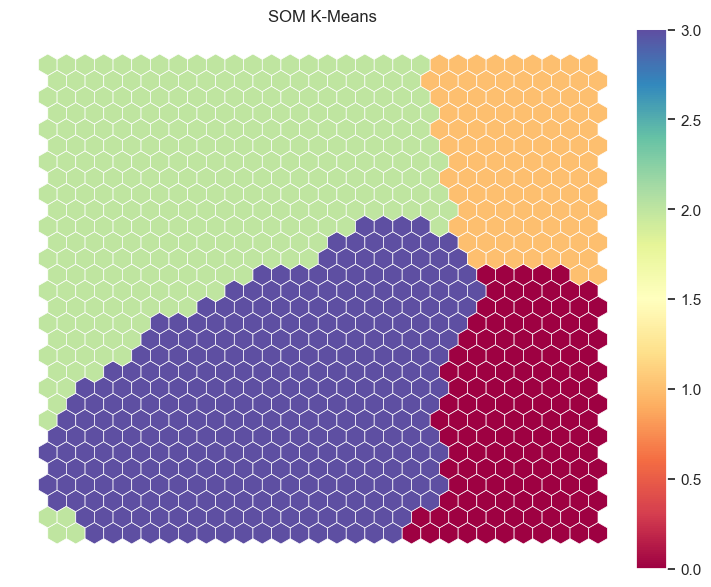

In [172]:
kmeans_matrix = value_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm_value, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

In [173]:
value_labels = predict_som_clusters(sm_value, som_data_value, kmeans_matrix)

In [174]:
df_value['value_labels'] = value_labels


C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\793521514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_value['value_labels'] = value_labels


C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\2656252870.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_value, x='value_labels', ax=axes[1], palette=["darkblue"])
C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\2656252870.py:16: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df_value, x='value_labels', ax=axes[1], palette=["darkblue"])


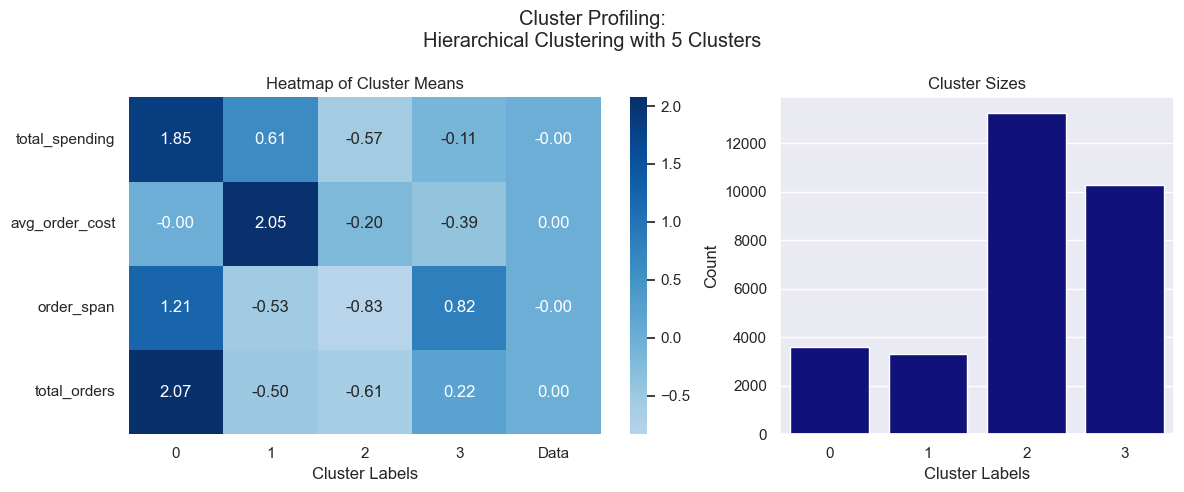

In [175]:
kmeans_profile = df_value.groupby('value_labels').mean().T
df_means = df_value[value_loyalty_feats].mean()
df_means.name = "Data"
kmeans_profile = pd.concat([kmeans_profile, df_means], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[0.6, 0.4], tight_layout=True)

sns.heatmap(kmeans_profile,
            center=0, annot=True, cmap="Blues", fmt=".2f",
            ax=axes[0])
axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)


sns.countplot(data=df_value, x='value_labels', ax=axes[1], palette=["darkblue"])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")
axes[1].set_ylabel("Count")

fig.suptitle("Cluster Profiling:\nHierarchical Clustering with 5 Clusters")
plt.show()

## PERSPECTIVE 2 - FINAL SOLUTION

In [176]:
preference_feats = ['cui_diversity_score', 'is_chain', 'dow_diversity_score']
df_preference = dfs[preference_feats]

In [177]:
M = 30
N = 30
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(preference_feats)
learning_rate = 0.7
sigma=2.2

som_data_preference = df_preference.values

sm_preference = MiniSom(M, N,             
             n_feats,           
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42,
             sigma=sigma
             )
som_data_preference = df_preference.values

sm_preference.random_weights_init(som_data_preference) 
sm_preference.train_batch(som_data_preference, 500000)

In [178]:
weights_flat_preference = sm_preference.get_weights().reshape((M*N),len(preference_feats))
weights_flat_preference.shape

(900, 3)

In [179]:
kmeans_preference = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)
preference_labels = kmeans_preference.fit_predict(weights_flat_preference)
kmeans_matrix = preference_labels.reshape((M,N))

In [180]:
preference_labels = predict_som_clusters(sm_preference, som_data_preference, kmeans_matrix)

In [181]:
df_preference['preference_labels'] = preference_labels

C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\2619262592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preference['preference_labels'] = preference_labels


C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\3336711198.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_preference, x='preference_labels', ax=axes[1], palette=["darkblue"])
C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\3336711198.py:16: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df_preference, x='preference_labels', ax=axes[1], palette=["darkblue"])


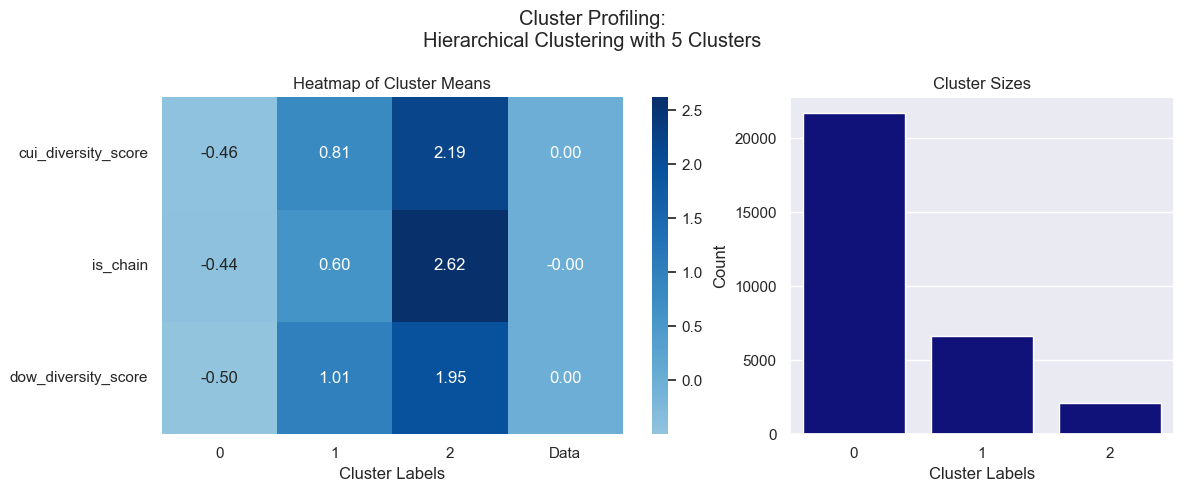

In [182]:
kmeans_profile = df_preference.groupby('preference_labels').mean().T
df_means = df_preference[preference_feats].mean()
df_means.name = "Data"
kmeans_profile = pd.concat([kmeans_profile, df_means], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[0.6, 0.4], tight_layout=True)

sns.heatmap(kmeans_profile,
            center=0, annot=True, cmap="Blues", fmt=".2f",
            ax=axes[0])
axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)


sns.countplot(data=df_preference, x='preference_labels', ax=axes[1], palette=["darkblue"])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")
axes[1].set_ylabel("Count")

fig.suptitle("Cluster Profiling:\nHierarchical Clustering with 5 Clusters")
plt.show()

## MERGING

In [183]:
df['value_labels'] = value_labels
df['preference_labels'] = preference_labels
#df['time_labels'] = time_labels

In [184]:
dfs['value_labels'] = value_labels
dfs['preference_labels'] = preference_labels
#dfs['time_labels'] = time_labels

In [185]:
features = preference_feats+value_loyalty_feats

In [186]:
df_centroids = dfs.groupby(['value_labels', 'preference_labels'])[features].mean()
df_centroids

cui_diversity_score  is_chain  \
value_labels preference_labels                                  
0            0                            -0.139507 -0.244776   
             1                             0.854532  0.558856   
             2                             2.196412  2.861010   
1            0                            -0.546995 -0.591335   
             1                             0.718583  0.190925   
2            0                            -0.575132 -0.494834   
             1                             0.682026  0.440020   
3            0                            -0.167032 -0.241358   
             1                             0.807265  0.669646   
             2                             2.153584  1.923429   

                                dow_diversity_score  total_spending  \
value_labels preference_labels                                        
0            0                             0.516028        2.146057   
             1                             1.527941        2.208858   
             2                             2.085644        1.398178   
1            0                            -0.591269        0.519607   
             1                             0.801615        1.642847   
2            0                            -0.673164       -0.576468   
             1                             0.585817       -0.354476   
3            0                            -0.096964       -0.200292   
             1                             0.844419        0.006475   
             2                             1.542918       -0.049709   

                                avg_order_cost  order_span  total_orders  
value_labels preference_labels                                            
0            0                        0.767794    1.104643      0.968259  
             1                        0.298690    1.159321      1.653972  
             2                       -0.464559    1.295663      2.729196  
1            0                        2.122725   -0.586693     -0.562348  
             1                        1.126963    0.115177      0.274099  
2            0                       -0.185634   -0.845342     -0.639306  
             1                       -0.638542   -0.532125      0.113542  
3            0                       -0.264231    0.777037     -0.135220  
             1                       -0.516451    0.844541      0.557512  
             2                       -0.801338    1.028516      1.377615

In [187]:
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

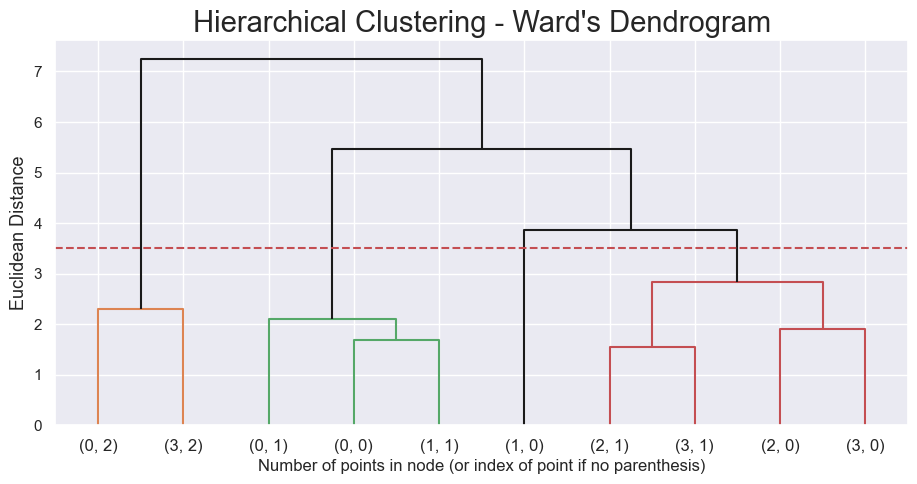

In [188]:

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)


for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))

y_threshold = 3.5

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [189]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  

cui_diversity_score  is_chain  \
value_labels preference_labels                                  
0            0                            -0.139507 -0.244776   
             1                             0.854532  0.558856   
             2                             2.196412  2.861010   
1            0                            -0.546995 -0.591335   
             1                             0.718583  0.190925   
2            0                            -0.575132 -0.494834   
             1                             0.682026  0.440020   
3            0                            -0.167032 -0.241358   
             1                             0.807265  0.669646   
             2                             2.153584  1.923429   

                                dow_diversity_score  total_spending  \
value_labels preference_labels                                        
0            0                             0.516028        2.146057   
             1                             1.527941        2.208858   
             2                             2.085644        1.398178   
1            0                            -0.591269        0.519607   
             1                             0.801615        1.642847   
2            0                            -0.673164       -0.576468   
             1                             0.585817       -0.354476   
3            0                            -0.096964       -0.200292   
             1                             0.844419        0.006475   
             2                             1.542918       -0.049709   

                                avg_order_cost  order_span  total_orders  \
value_labels preference_labels                                             
0            0                        0.767794    1.104643      0.968259   
             1                        0.298690    1.159321      1.653972   
             2                       -0.464559    1.295663      2.729196   
1            0                        2.122725   -0.586693     -0.562348   
             1                        1.126963    0.115177      0.274099   
2            0                       -0.185634   -0.845342     -0.639306   
             1                       -0.638542   -0.532125      0.113542   
3            0                       -0.264231    0.777037     -0.135220   
             1                       -0.516451    0.844541      0.557512   
             2                       -0.801338    1.028516      1.377615   

                                hclust_labels  
value_labels preference_labels                 
0            0                              2  
             1                              2  
             2                              1  
1            0                              3  
             1                              2  
2            0                              0  
             1                              0  
3            0                              0  
             1                              0  
             2                              1

In [190]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 2,
 (0, 1): 2,
 (0, 2): 1,
 (1, 0): 3,
 (1, 1): 2,
 (2, 0): 0,
 (2, 1): 0,
 (3, 0): 0,
 (3, 1): 0,
 (3, 2): 1}

In [191]:
df_ = dfs.copy()

df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['preference_labels'])
    ], axis=1
)

df_ 

customer_age  vendor_count  product_count  is_chain  first_order  \
customer_id                                                                     
1b8f824d5e      -1.335376     -0.395506       0.081035 -0.542328    -1.212516   
5d272b9dcb      -1.476403     -0.395506      -0.686823 -0.140633    -1.212516   
f6d1b2ba63       1.485174     -0.888068      -0.686823 -0.140633    -1.212516   
180c632ed8      -0.207156     -0.395506      -0.430871 -0.542328    -1.212516   
4eb37a6705      -1.053321     -0.395506       0.081035 -0.944024    -1.212516   
...                   ...           ...            ...       ...          ...   
f4e366c281       0.356954     -0.888068      -0.942776 -0.542328    -1.212516   
f6b6709018      -0.207156     -0.888068      -0.942776 -0.944024    -1.212516   
f74ad8ce3f      -0.489211     -0.888068      -0.942776 -0.542328    -1.212516   
f7b19c0241       0.921064     -0.888068      -0.942776 -0.944024    -1.212516   
fd40d3b0e0       0.356954     -0.888068      -0.942776 -0.944024    -1.212516   

             last_order  CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
customer_id                                                                 
1b8f824d5e    -2.667819     -0.447212  -0.475690      -0.281924 -0.144681   
5d272b9dcb    -2.667819      0.877329  -0.134410      -0.281924 -0.144681   
f6d1b2ba63    -2.667819      0.503317  -0.475690      -0.281924 -0.144681   
180c632ed8    -2.624751     -0.447212   0.256005      -0.281924 -0.144681   
4eb37a6705    -2.624751      1.058136   1.707113      -0.281924 -0.144681   
...                 ...           ...        ...            ...       ...   
f4e366c281    -2.710886     -0.447212  -0.475690       2.197080 -0.144681   
f6b6709018    -2.710886      1.416650  -0.475690      -0.281924 -0.144681   
f74ad8ce3f    -2.710886     -0.447212  -0.475690      -0.281924 -0.144681   
f7b19c0241    -2.710886     -0.447212   0.166813      -0.281924 -0.144681   
fd40d3b0e0    -2.710886     -0.447212  -0.475690      -0.281924 -0.144681   

             ...  order_span  avg_product_cost  avg_order_cost  \
customer_id  ...                                                 
1b8f824d5e   ...   -1.145656         -0.458137        0.525391   
5d272b9dcb   ...   -1.145656          0.481152       -0.095357   
f6d1b2ba63   ...   -1.145656         -0.746620       -0.737931   
180c632ed8   ...   -1.110690          0.705609        0.697429   
4eb37a6705   ...   -1.110690          0.844945        2.230362   
...          ...         ...               ...             ...   
f4e366c281   ...   -1.180621          2.550333        0.987582   
f6b6709018   ...   -1.180621          2.550333        0.987582   
f74ad8ce3f   ...   -1.180621          2.489006        0.955486   
f7b19c0241   ...   -1.180621          1.076026        0.215980   
fd40d3b0e0   ...   -1.180621          0.065353       -0.312972   

             products_per_vendor  cui_diversity_score  dow_diversity_score  \
customer_id                                                                  
1b8f824d5e              0.828713            -0.903579            -0.390011   
5d272b9dcb             -0.731839            -0.123455            -0.390011   
f6d1b2ba63              0.308529            -0.903579            -0.390011   
180c632ed8             -0.211655            -0.123455            -0.390011   
4eb37a6705              0.828713            -0.123455            -0.390011   
...                          ...                  ...                  ...   
f4e366c281             -0.731839            -0.903579            -1.063307   
f6b6709018             -0.731839            -0.903579            -1.063307   
f74ad8ce3f             -0.731839            -0.903579            -1.063307   
f7b19c0241             -0.731839            -0.903579            -1.063307   
fd40d3b0e0             -0.731839            -0.903579            -1.063307   

             hr_diversity_score  value_labels  preference_labels  \
customer_id    

In [192]:
df_.groupby('merged_labels').mean(numeric_only=True)[features]

cui_diversity_score  is_chain  dow_diversity_score  \
merged_labels                                                       
0                        -0.200375 -0.204263            -0.232874   
1                         2.185368  2.619256             1.945703   
2                         0.733827  0.432816             1.340226   
3                        -0.546995 -0.591335            -0.591269   

               total_spending  avg_order_cost  order_span  total_orders  
merged_labels                                                            
0                   -0.375073       -0.274069   -0.137752     -0.285277  
1                    1.024841       -0.551397    1.226780      2.380691  
2                    2.139757        0.439923    1.038353      1.428870  
3                    0.519607        2.122725   -0.586693     -0.562348

In [193]:
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

0
merged_labels       
0              22992
1               2102
2               2285
3               3041

In [194]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])


        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) 
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\2710319279.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=label,
C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\2710319279.py:31: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=label,
C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\2710319279.py:31: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=label,


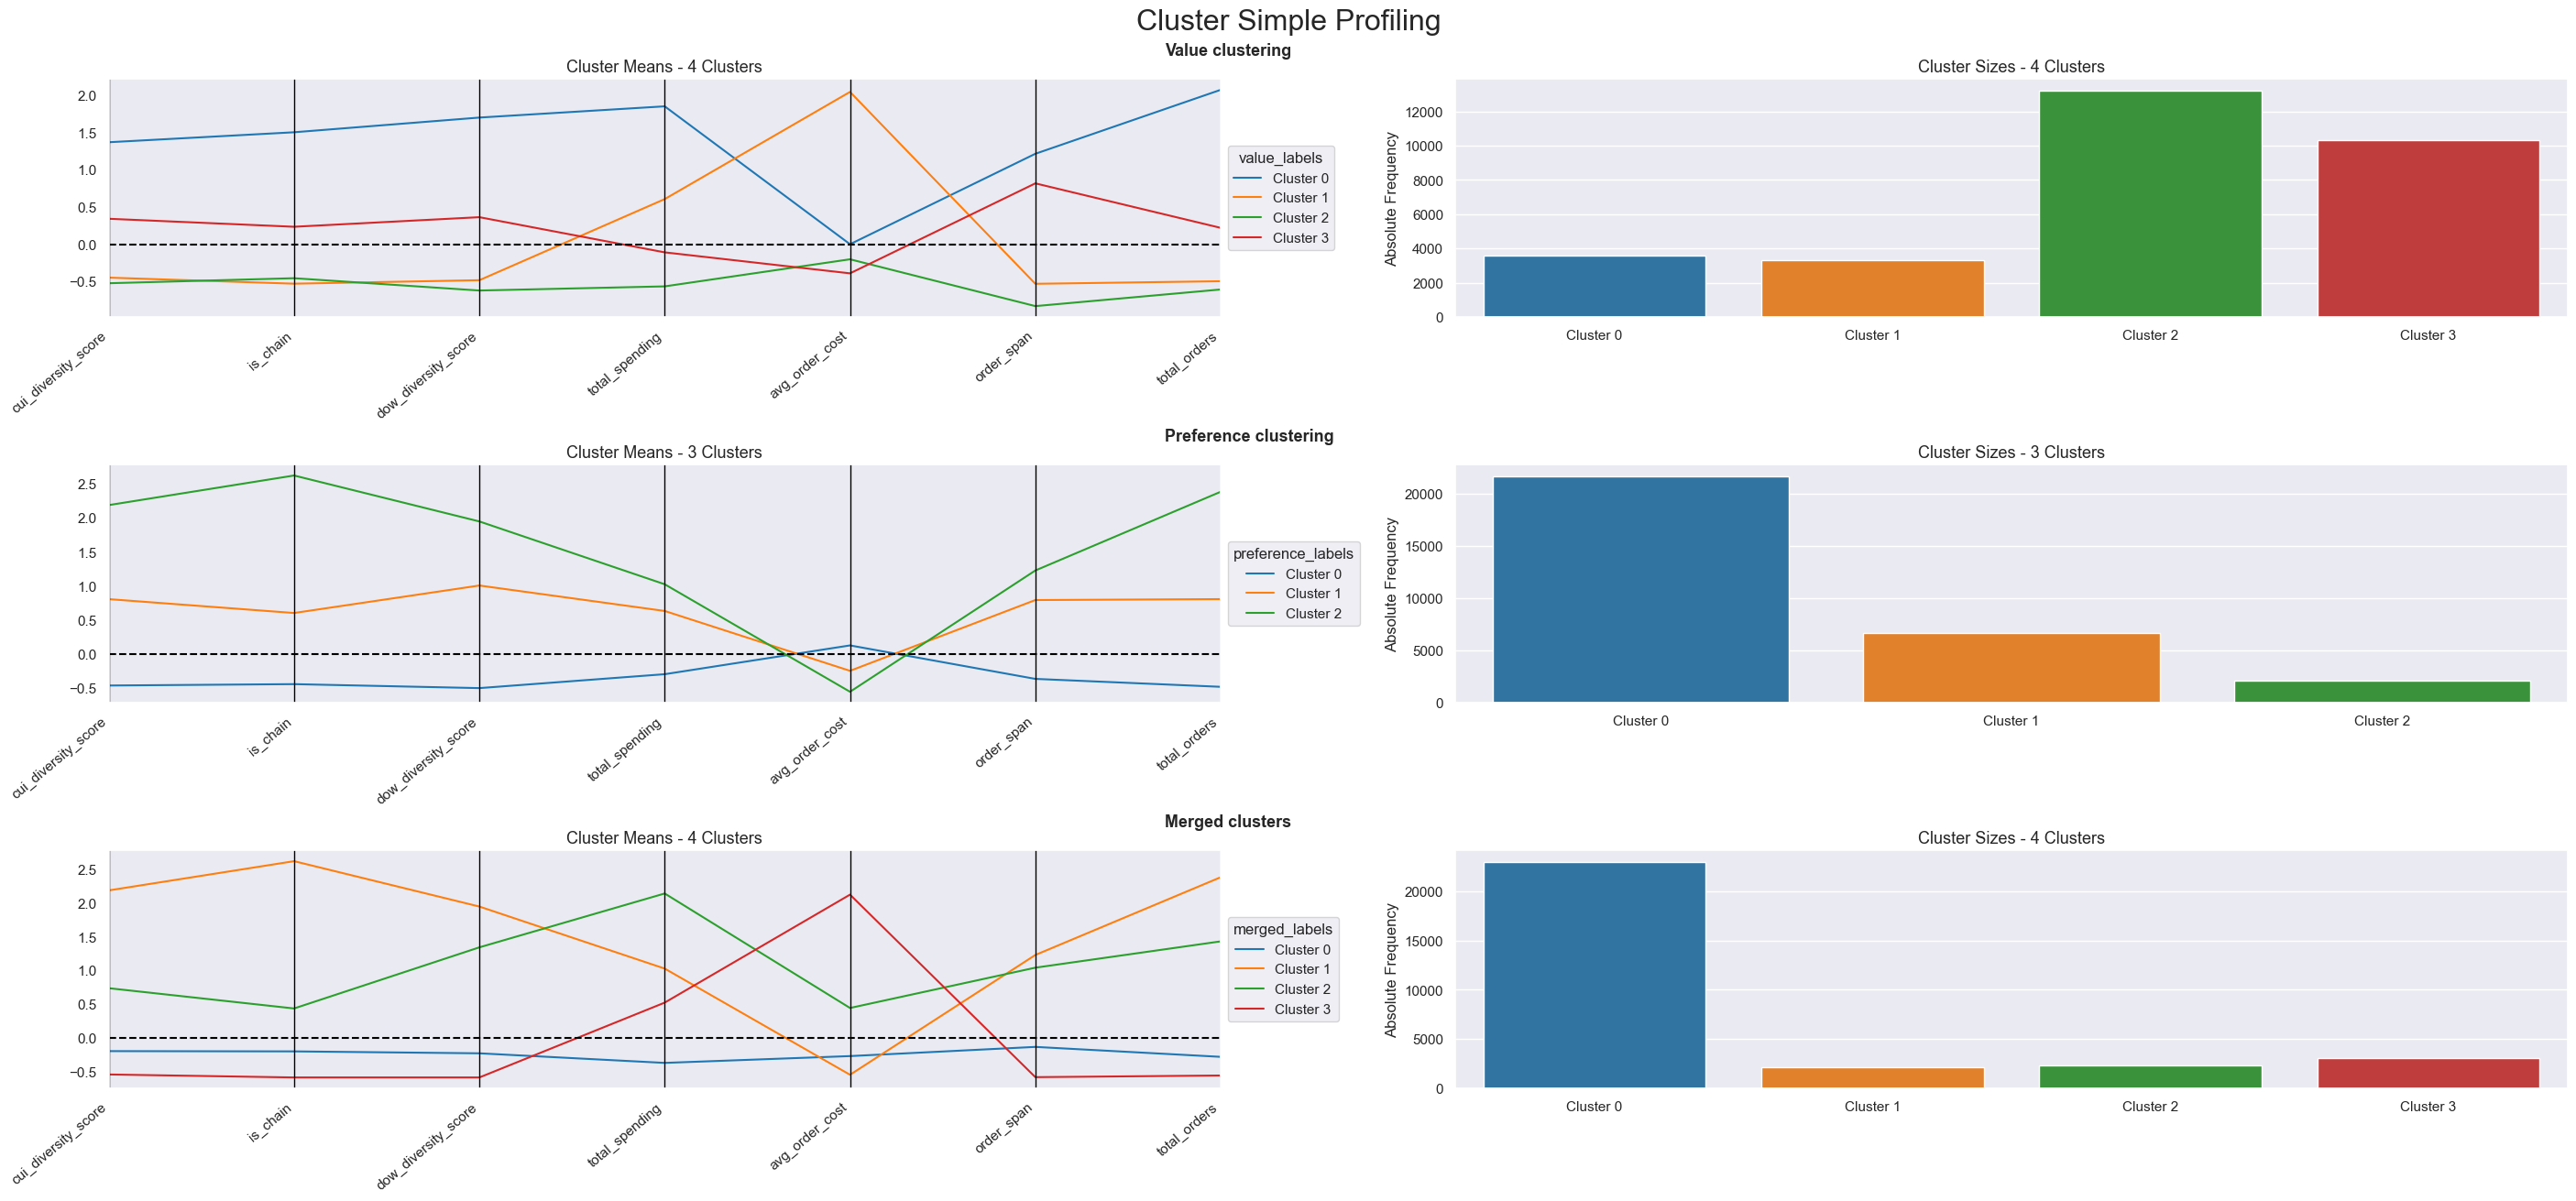

In [195]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_[features + ['value_labels', 'preference_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'preference_labels','merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Value clustering", "Preference clustering", "Merged clusters"]
)

In [196]:
score = silhouette_score(df_, df_['merged_labels'])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.11640512140050648


In [197]:
df_sst_ = get_ss(df_, features)
df_ssb_ = get_ssb(df_, features, 'merged_labels')
df_ssw_ = get_ssw(df_, features, 'merged_labels')
df_rsq_ = get_rsq(df_, features, 'merged_labels')

print("SSb:  ", df_ssb_)
print("SSw:  ", df_ssw_)
print("SSt:  ", df_sst_)
print("R2: ", df_rsq_)

SSb:   104103.68993298702
SSw:   108836.31006701295
SSt:   212940.0
R2:  0.4888874327650373


In [198]:
df_['merged_labels'].value_counts()

merged_labels
0    22992
3     3041
2     2285
1     2102
Name: count, dtype: int64

We have an imbalanced cluster solution. The cluster with the majority of the customers represent low spending little engaged customer. Cluster 1 and 2 have engaged customers, that differ mostly on the type of orders they place and on the diversity of cuisines they order from. Cluster 3 have little engaged customers that order few times but spend a lot of monetary units per order.

`CLuster 0` correspond to our loyal customers, that have been users for the longest time, have the most orders and are the most diverse. However, as they do not spend much per order, they are not our highest spending customers.

`Cluster 1` represent our best customers in terms of monetary expenditure. In addition to this, they do not have a specific preference for the day of the week they order.

`Cluster 2` correspond to our potential great customers, as even tho they have not been using our business for long they still managed to have a high total spending due to their elevated expenditure per order.


`Cluster 3` correspond to our inconsistent and sporadic customers. They have been users for some time, but they have not ordered much and when they do they do not spend a lot. Also, they do not have a specific preference for when and for what specific vendors they buy.

In [199]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [200]:
r2_variables(df_[features + ['merged_labels']], 'merged_labels').drop('merged_labels')

cui_diversity_score    0.430713
is_chain               0.554618
dow_diversity_score    0.472452
total_spending         0.549812
avg_order_cost         0.542766
order_span             0.233733
total_orders           0.638117
dtype: float64

## SEMI-SUPERVISED LEARNING

In [201]:
df_.columns

Index(['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order', 'CUI_American', 'CUI_Asian',
       'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese',
       'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian',
       'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER',
       'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2',
       'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19',
       'HR_20', 'HR_21', 'HR_22', 'HR_23', 'late_night', 'early_morning',
       'morning', 'midday', 'afternoon_evening', 'night', 'weekday', 'weekend',
       'total_spending', 'total_orders', 'order_frequency', 'order_span',
       'avg_product_cost', 'avg_order_cost', 'products_per_vendor',
       'cui_diversity_score', 'dow_diversity_score', 'hr_diversity_score'

In [202]:
metric_features = ['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order',
       'total_spending', 'total_orders', 'order_frequency', 'order_span',
       'avg_product_cost', 'avg_order_cost', 'products_per_vendor',
       'cui_diversity_score', 'dow_diversity_score', 'hr_diversity_score']

In [203]:
# Preparing the data
X = df_[features]
y = df_.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 93.43% of the customers correctly


In [204]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

total_orders           0.419586
avg_order_cost         0.397717
is_chain               0.092406
total_spending         0.090291
cui_diversity_score    0.000000
dow_diversity_score    0.000000
order_span             0.000000
dtype: float64

In [205]:
df_['merged_labels'] = dt.predict(df_[features])
df_.head()

customer_age  vendor_count  product_count  is_chain  first_order  \
customer_id                                                                     
1b8f824d5e      -1.335376     -0.395506       0.081035 -0.542328    -1.212516   
5d272b9dcb      -1.476403     -0.395506      -0.686823 -0.140633    -1.212516   
f6d1b2ba63       1.485174     -0.888068      -0.686823 -0.140633    -1.212516   
180c632ed8      -0.207156     -0.395506      -0.430871 -0.542328    -1.212516   
4eb37a6705      -1.053321     -0.395506       0.081035 -0.944024    -1.212516   

             last_order  CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
customer_id                                                                 
1b8f824d5e    -2.667819     -0.447212  -0.475690      -0.281924 -0.144681   
5d272b9dcb    -2.667819      0.877329  -0.134410      -0.281924 -0.144681   
f6d1b2ba63    -2.667819      0.503317  -0.475690      -0.281924 -0.144681   
180c632ed8    -2.624751     -0.447212   0.256005      -0.281924 -0.144681   
4eb37a6705    -2.624751      1.058136   1.707113      -0.281924 -0.144681   

             ...  order_span  avg_product_cost  avg_order_cost  \
customer_id  ...                                                 
1b8f824d5e   ...   -1.145656         -0.458137        0.525391   
5d272b9dcb   ...   -1.145656          0.481152       -0.095357   
f6d1b2ba63   ...   -1.145656         -0.746620       -0.737931   
180c632ed8   ...   -1.110690          0.705609        0.697429   
4eb37a6705   ...   -1.110690          0.844945        2.230362   

             products_per_vendor  cui_diversity_score  dow_diversity_score  \
customer_id                                                                  
1b8f824d5e              0.828713            -0.903579            -0.390011   
5d272b9dcb             -0.731839            -0.123455            -0.390011   
f6d1b2ba63              0.308529            -0.903579            -0.390011   
180c632ed8             -0.211655            -0.123455            -0.390011   
4eb37a6705              0.828713            -0.123455            -0.390011   

             hr_diversity_score  value_labels  preference_labels  \
customer_id                                                        
1b8f824d5e            -0.974013             2                  0   
5d272b9dcb            -0.404062             2                  0   
f6d1b2ba63            -0.404062             2                  0   
180c632ed8            -0.404062             2                  0   
4eb37a6705            -0.404062             1                  0   

             merged_labels  
customer_id                 
1b8f824d5e               0  
5d272b9dcb               0  
f6d1b2ba63               0  
180c632ed8               0  
4eb37a6705               3  

[5 rows x 73 columns]

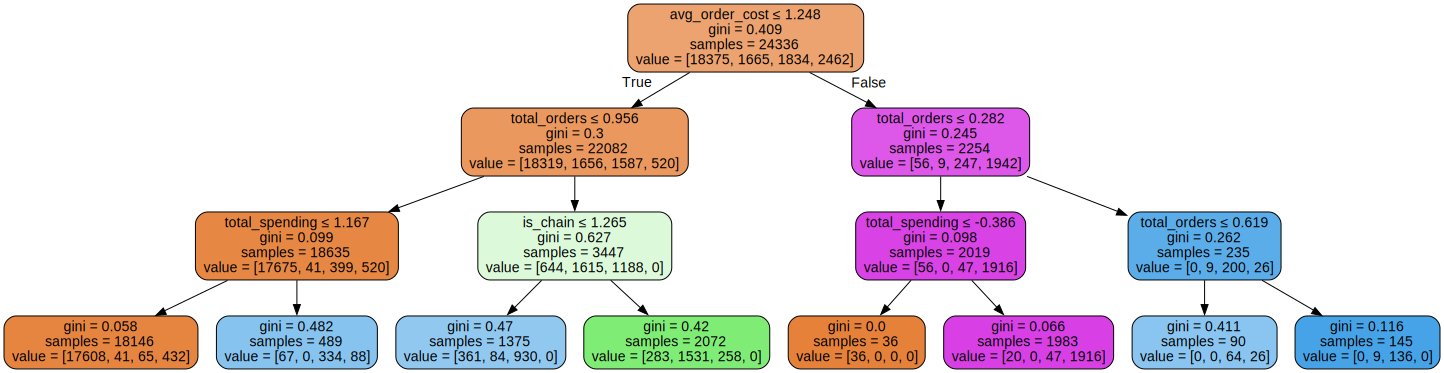

In [206]:
dot_data = export_graphviz(dt, out_file=None, 
                            feature_names=X.columns.to_list(),
                            filled=True,
                            rounded=True,
                            special_characters=True)
g = graphviz.Source(dot_data)

g


C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\968667120.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_, x='merged_labels', ax=axes[1], palette=["darkblue"])
C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\968667120.py:20: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df_, x='merged_labels', ax=axes[1], palette=["darkblue"])


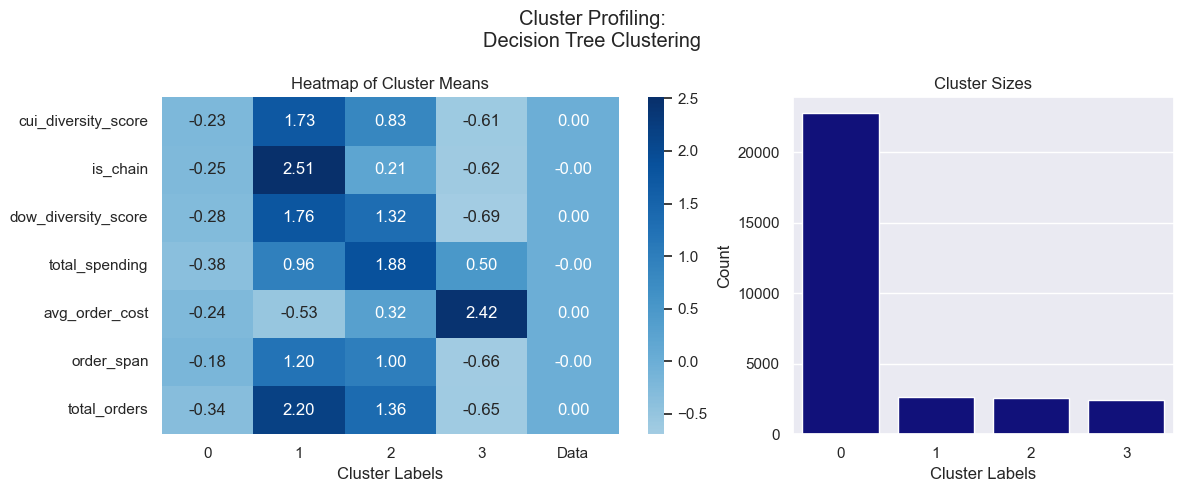

In [207]:
dt_profile = df_.groupby('merged_labels')[features].mean().T

# Calculate global means for comparison (optional)
df_means = df_[features].mean()
df_means.name = "Data"
dt_profile = pd.concat([dt_profile, df_means], axis=1)

# Set up the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[0.6, 0.4], tight_layout=True)

# Heatmap for cluster means
sns.heatmap(dt_profile,
            center=0, annot=True, cmap="Blues", fmt=".2f",
            ax=axes[0])
axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Bar plot for cluster sizes
sns.countplot(data=df_, x='merged_labels', ax=axes[1], palette=["darkblue"])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")
axes[1].set_ylabel("Count")

# Set an overall title for the figure
fig.suptitle("Cluster Profiling:\nDecision Tree Clustering")
plt.show()


In [208]:
sil_score = silhouette_score(df_[features], df_['merged_labels'])
print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: 0.30


In [209]:
df_sst_ = get_ss(df_, features)
df_ssb_ = get_ssb(df_, features, 'merged_labels')
df_ssw_ = get_ssw(df_, features, 'merged_labels')
df_rsq_ = get_rsq(df_, features, 'merged_labels')

print("SSb:  ", df_ssb_)
print("SSw:  ", df_ssw_)
print("SSt:  ", df_sst_)
print("R2: ", df_rsq_)

SSb:   107489.0243799292
SSw:   105450.97562007078
SSt:   212940.0
R2:  0.5047855000466293


In [210]:
df_['merged_labels'].value_counts()

merged_labels
0    22753
1     2615
2     2588
3     2464
Name: count, dtype: int64

After training a decision tree model with the cluster labels as target, we understand we have a better cluster solution, similar to the one found above, but with an increased silloute score and r^2.

# PROFILING

### Predicting Outliers

In [211]:
outliers = pd.read_csv('outlier_dataset.csv')

In [212]:
outliers_scaled = pd.read_csv("outlier_dataset_scaled.csv")

In [213]:
outliers.set_index('customer_id', inplace= True)

In [214]:
outliers_scaled.set_index('customer_id', inplace= True)

In [215]:
outliers.describe()

customer_region  customer_age  vendor_count  product_count  \
count      1252.000000   1252.000000   1252.000000    1252.000000   
mean       4232.987220     27.610224     10.756390      30.303514   
std        2310.584388      6.974992      5.774382      15.012669   
min           8.000000     15.000000      1.000000       5.000000   
25%        2360.000000     23.000000      7.000000      22.000000   
50%        4400.000000     26.000000     10.000000      26.000000   
75%        4660.000000     30.000000     14.000000      34.000000   
max        8670.000000     68.000000     41.000000     269.000000   

          is_chain  first_order   last_order  CUI_American    CUI_Asian  \
count  1252.000000  1252.000000  1252.000000   1252.000000  1252.000000   
mean     14.515176     6.587859    83.550319     18.842508    36.765335   
std      10.436160    10.179890     9.034698     31.162712    69.657523   
min       0.000000     0.000000    12.000000      0.000000     0.000000   
25%       8.000000     1.000000    83.000000      0.000000     0.000000   
50%      13.000000     3.000000    87.000000      6.405000     6.895000   
75%      19.000000     7.000000    88.000000     23.120000    40.860000   
max      83.000000    75.000000    90.000000    280.210000   896.710000   

       CUI_Beverages  ...   used_promo  broader_region  order_frequency  \
count    1252.000000  ...  1252.000000     1252.000000      1252.000000   
mean        8.540160  ...     0.337859        3.785942         4.025271   
std        22.285141  ...     0.473169        2.198508         1.785201   
min         0.000000  ...     0.000000        2.000000         0.000000   
25%         0.000000  ...     0.000000        2.000000         3.070238   
50%         0.000000  ...     0.000000        4.000000         3.888889   
75%         6.675000  ...     1.000000        4.000000         4.692096   
max       229.220000  ...     1.000000        8.000000        29.000000   

        order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  1252.000000       1252.000000     1252.000000          1252.000000   
mean     76.962460          5.869214        9.278164             4.007099   
std      14.411871          2.977016        9.364109             4.250517   
min       0.000000          0.774286        0.774286             1.130435   
25%      74.000000          3.458291        4.700085             2.083333   
50%      82.000000          5.157314        6.806989             2.750000   
75%      86.000000          7.549588       10.641127             4.125000   
max      90.000000         18.232000      104.320000            70.000000   

       cui_diversity_score  dow_diversity_score  hr_diversity_score  
count          1252.000000          1252.000000         1252.000000  
mean              5.385783             6.328275            8.384984  
std               2.348642             1.054881            2.974504  
min               1.000000             1.000000            1.000000  
25%               4.000000             6.000000            6.000000  
50%               5.000000             7.000000            8.000000  
75%               7.000000             7.000000           10.000000  
max              13.000000             7.000000           19.000000  

[8 rows x 73 columns]

In [216]:
outliers_scaled.describe()

customer_age  vendor_count  product_count     is_chain  first_order  \
count   1252.000000   1252.000000    1252.000000  1252.000000  1252.000000   
mean       0.019930      3.917553       6.557539     4.886656    -0.938767   
std        0.983666      2.844238       3.842534     4.192158     0.423010   
min       -1.758458     -0.888068       0.081035    -0.944024    -1.212516   
25%       -0.630238      2.067301       4.432231     2.269540    -1.170962   
50%       -0.207156      3.544985       5.456042     4.278017    -1.087855   
75%        0.356954      5.515231       7.503664     6.688190    -0.921641   
max        5.715999     18.814389      67.652556    32.396699     1.903994   

        last_order  CUI_American    CUI_Asian  CUI_Beverages     CUI_Cafe  \
count  1252.000000   1252.000000  1252.000000    1252.000000  1252.000000   
mean      0.887413      1.499564     1.487889       0.891640     2.184502   
std       0.389101      3.219679     3.720300       3.062358     7.587324   
min      -2.194077     -0.447212    -0.475690      -0.281924    -0.144681   
25%       0.863712     -0.447212    -0.475690      -0.281924    -0.144681   
50%       1.035982      0.214542    -0.107439      -0.281924    -0.144681   
75%       1.079049      1.941508     1.706579       0.635335    -0.144681   
max       1.165184     28.503613    47.416201      31.216813    93.316643   

       ...  total_spending  total_orders  order_frequency   order_span  \
count  ...     1252.000000   1252.000000      1252.000000  1252.000000   
mean   ...        4.414371      6.197666        -0.580756     1.510396   
std    ...        3.525869      3.645003         0.223415     0.503916   
min    ...       -0.879160     -0.897965        -1.084511    -1.180621   
25%    ...        1.848781      4.159571        -0.700276     1.406813   
50%    ...        3.541513      5.508247        -0.597824     1.686535   
75%    ...        5.888024      7.194092        -0.497304     1.826397   
max    ...       44.153386     30.458754         2.544790     1.966258   

       avg_product_cost  avg_order_cost  products_per_vendor  \
count       1252.000000     1252.000000          1252.000000   
mean          -0.435270       -0.137318             2.396650   
std            0.730289        1.202224             4.422101   
min           -1.685102       -1.229100            -0.596139   
25%           -1.026691       -0.725081             0.395226   
50%           -0.609906       -0.454583             1.088805   
75%           -0.023059        0.037668             2.519311   
max            2.597433       12.064758            71.053549   

       cui_diversity_score  dow_diversity_score  hr_diversity_score  
count          1252.000000          1252.000000         1252.000000  
mean              2.517873             2.524197            3.235065  
std               1.832231             0.710246            1.695321  
min              -0.903579            -1.063307           -0.974013  
25%               1.436791             2.303171            1.875741  
50%               2.216915             2.976466            3.015643  
75%               3.777162             2.976466            4.155545  
max               8.457902             2.976466            9.285102  

[8 rows x 70 columns]

In [217]:
outliers_scaled['merged_labels'] = dt.predict(outliers_scaled[features])
outliers_scaled.head()

customer_age  vendor_count  product_count  is_chain  first_order  \
customer_id                                                                     
d5cbe9cd02       0.497982      2.067301       5.456042  3.876322    -1.212516   
9c5d8d6747      -0.066128      1.082178       6.991759  8.294971    -1.212516   
4d43db4f0a       0.921064      1.082178       5.967948  7.089885    -1.212516   
7b0661a6ba       0.356954     -0.888068       3.664373  4.679712    -1.212516   
d6e5be6382       1.203119      2.559862       5.200090  1.466149    -1.212516   

             last_order  CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  \
customer_id                                                                 
d5cbe9cd02    -1.634200     -0.447212  -0.475690       3.440704  0.494445   
9c5d8d6747    -1.504998     -0.447212   0.634671      -0.281924 -0.144681   
4d43db4f0a    -0.902053      8.272854  -0.475690      -0.281924 -0.144681   
7b0661a6ba    -0.858986     -0.447212  -0.475690      -0.281924 -0.144681   
d6e5be6382    -0.600581      8.132341  -0.475690      -0.281924 -0.144681   

             ...  total_orders  order_frequency  order_span  avg_product_cost  \
customer_id  ...                                                                
d5cbe9cd02   ...      4.159571        -0.888967   -0.306488         -0.960511   
9c5d8d6747   ...      6.519754        -0.932157   -0.201592         -0.872341   
4d43db4f0a   ...      5.845416        -0.834215    0.287923         -0.915095   
7b0661a6ba   ...      3.485233        -0.700127    0.322888         -1.218388   
d6e5be6382   ...      5.845416        -0.792499    0.532680         -0.850435   

             avg_order_cost  products_per_vendor  cui_diversity_score  \
customer_id                                                             
d5cbe9cd02        -0.550727             2.092017             2.216915   
9c5d8d6747        -0.598380             4.886148             0.656668   
4d43db4f0a        -0.658637             4.053853             0.656668   
7b0661a6ba        -0.862098            17.994784            -0.903579   
d6e5be6382        -0.690122             1.478943             0.656668   

             dow_diversity_score  hr_diversity_score  merged_labels  
customer_id                                                          
d5cbe9cd02              1.629875            4.725496              1  
9c5d8d6747              2.303171            2.445692              1  
4d43db4f0a              2.303171            3.015643              1  
7b0661a6ba              2.303171            2.445692              1  
d6e5be6382              2.303171            4.155545              1  

[5 rows x 71 columns]

In [218]:
outliers_scaled['merged_labels'].value_counts()

merged_labels
1    1016
2     220
3      14
0       2
Name: count, dtype: int64

In [219]:
outliers['merged_labels']=outliers_scaled['merged_labels']

In [220]:
df['merged_labels']=df_['merged_labels']

In [221]:
df.drop(columns=['value_labels', 'preference_labels'], inplace=True)

In [222]:
len(df.columns)

77

In [223]:
len(outliers.columns)

77

In [224]:
df = pd.concat([df, outliers])

In [225]:
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

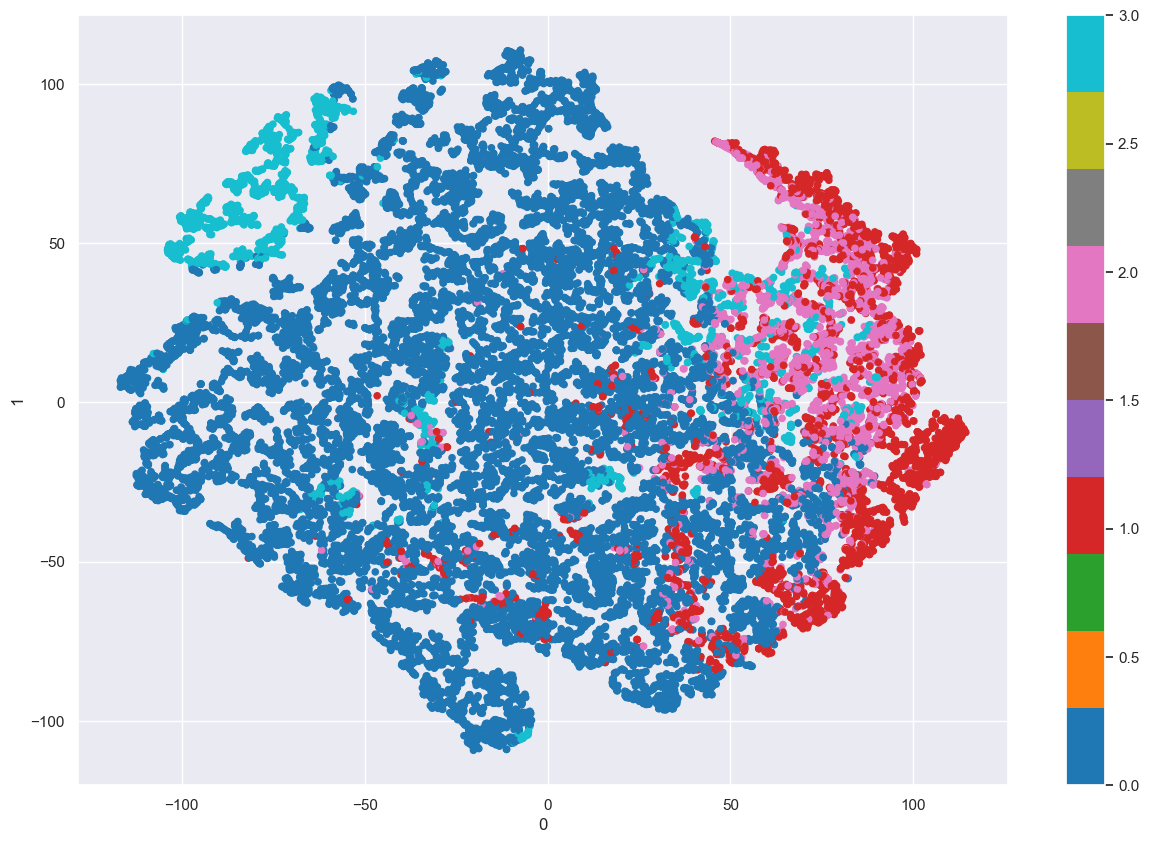

In [226]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Favorite cuisine spending proportion and auxiliar steps

This feature will help us on profiling the cluster

In [227]:
cuisine_columns = [col for col in df.columns if col.startswith('CUI_')]

In [228]:
# Calculate the favorite cuisine and its proportion
def calculate_favourite_cuisine_proportion(row):
    # Extract cuisine spending columns
    # Identify the favorite cuisine spending
    favourite_cuisine_spending = row[cuisine_columns].max()
    # Calculate the proportion of spending in the favorite cuisine
    return favourite_cuisine_spending / row['total_spending']

# Apply the function to calculate the proportion
df['favourite_cuisine_proportion'] = df.apply(calculate_favourite_cuisine_proportion, axis=1)

DataFrames created to help in profiling

In [229]:
filtered_df_0 = df[df['merged_labels']==0]
filtered_df_1 = df[df['merged_labels']==1]
filtered_df_2 = df[df['merged_labels']==2]
filtered_df_3 = df[df['merged_labels']==3]

### Key statistics and queries for each cluster

In [230]:
columns_of_interst=['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order', 'total_spending', 'total_orders', 'order_frequency', 'order_span', 'avg_product_cost', 'avg_order_cost', 'products_per_vendor', 'cui_diversity_score']

In [231]:
filtered_df_0[columns_of_interst].describe()

customer_age  vendor_count  product_count      is_chain   first_order  \
count  22755.000000  22755.000000   22755.000000  22755.000000  22755.000000   
mean      27.450363      2.217139       3.201934      1.740013     31.693430   
std        7.095875      1.176409       1.906894      1.448387     24.071768   
min       15.000000      1.000000       1.000000      0.000000      0.000000   
25%       23.000000      1.000000       2.000000      1.000000     11.000000   
50%       26.000000      2.000000       3.000000      1.000000     27.000000   
75%       31.000000      3.000000       4.000000      3.000000     49.000000   
max       80.000000      6.000000      15.000000      6.000000     90.000000   

         last_order  total_spending  total_orders  order_frequency  \
count  22755.000000    22755.000000  22755.000000     22755.000000   
mean      60.286882       21.153216      2.665876         9.178920   
std       23.423333       14.357098      1.433882         8.602156   
min        0.000000        0.370000      1.000000         0.000000   
25%       45.000000       10.340000      2.000000         0.000000   
50%       66.000000       18.080000      2.000000         8.000000   
75%       80.000000       29.295000      4.000000        14.333333   
max       90.000000       69.610000      6.000000        44.500000   

         order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  22755.000000      22755.000000    22755.000000         22755.000000   
mean      28.593452          7.182318        8.496662             1.505258   
std       26.079477          3.847864        4.626083             0.802120   
min        0.000000          0.370000        0.370000             1.000000   
25%        0.000000          4.101000        4.870000             1.000000   
50%       24.000000          6.515000        7.670000             1.250000   
75%       50.000000          9.393929       11.685500             1.666667   
max       90.000000         20.830000       20.880000            12.000000   

       cui_diversity_score  
count         22755.000000  
mean              1.866667  
std               0.922206  
min               1.000000  
25%               1.000000  
50%               2.000000  
75%               2.000000  
max               6.000000

In [232]:
filtered_df_0[filtered_df_0['order_span']==90][columns_of_interst]

customer_age  vendor_count  product_count  is_chain  first_order  \
customer_id                                                                     
a210f7cea9           23.0             1              3         3          0.0   

             last_order  total_spending  total_orders  order_frequency  \
customer_id                                                              
a210f7cea9           90            6.33             3             30.0   

             order_span  avg_product_cost  avg_order_cost  \
customer_id                                                 
a210f7cea9         90.0              2.11            2.11   

             products_per_vendor  cui_diversity_score  
customer_id                                            
a210f7cea9                   3.0                    1

In [233]:
filtered_df_0[filtered_df_0['order_span']>50][columns_of_interst]

customer_age  vendor_count  product_count  is_chain  first_order  \
customer_id                                                                     
4dfcf12da4           24.0             3              4         3          0.0   
aede6a3935           25.0             2              3         0          0.0   
b570477f78           34.0             2              2         2          0.0   
f1ec473259           26.0             2              2         2          0.0   
fbd5b7a1c5           28.0             3              5         4          0.0   
...                   ...           ...            ...       ...          ...   
71f1638fd0           22.0             5              7         3         38.0   
cedc957515           27.0             2              2         0         38.0   
d218007b0e           20.0             5              5         2         38.0   
fc8a659ff2           33.0             6              7         3         38.0   
fc000d4a4b           25.0             5              7         6         38.0   

             last_order  total_spending  total_orders  order_frequency  \
customer_id                                                              
4dfcf12da4           51           41.97             3        17.000000   
aede6a3935           51           18.60             3        17.000000   
b570477f78           51            6.98             2        25.500000   
f1ec473259           51           15.95             2        25.500000   
fbd5b7a1c5           51           17.64             4        12.750000   
...                 ...             ...           ...              ...   
71f1638fd0           89           61.38             6         8.500000   
cedc957515           89           17.06             2        25.500000   
d218007b0e           89           32.39             5        10.200000   
fc8a659ff2           89           61.73             6         8.500000   
fc000d4a4b           90           27.48             6         8.666667   

             order_span  avg_product_cost  avg_order_cost  \
customer_id                                                 
4dfcf12da4         51.0         10.492500       13.990000   
aede6a3935         51.0          6.200000        6.200000   
b570477f78         51.0          3.490000        3.490000   
f1ec473259         51.0          7.975000        7.975000   
fbd5b7a1c5         51.0          3.528000        4.410000   
...                 ...               ...             ...   
71f1638fd0         51.0          8.768571       10.230000   
cedc957515         51.0          8.530000        8.530000   
d218007b0e         51.0          6.478000        6.478000   
fc8a659ff2         51.0          8.818571       10.288333   
fc000d4a4b         52.0          3.925714        4.580000   

             products_per_vendor  cui_diversity_score  
customer_id                                            
4dfcf12da4              1.333333                    2  
aede6a3935              1.500000                    2  
b570477f78              1.000000                    2  
f1ec473259              1.000000                    2  
fbd5b7a1c5              1.666667                    3  
...                          ...                  ...  
71f1638fd0              1.400000                    2  
cedc957515              1.000000                    2  
d218007b0e              1.000000                    5  
fc8a659ff2              1.166667                    5  
fc000d4a4b              1.400000                    5  

[5546 rows x 14 columns]

In [234]:
filtered_df_0.groupby('used_promo')['total_orders'].mean()

used_promo
0    2.926665
1    2.402807
Name: total_orders, dtype: float64

In [235]:
filtered_df_1[columns_of_interst].describe()

customer_age  vendor_count  product_count     is_chain  first_order  \
count   3631.000000   3631.000000    3631.000000  3631.000000  3631.000000   
mean      27.488846      8.050399      17.977692    11.005784     9.563481   
std        6.950619      4.307971      12.176607     6.728560    11.624463   
min       15.000000      1.000000       7.000000     6.000000     0.000000   
25%       23.000000      5.000000      11.000000     7.000000     2.000000   
50%       26.000000      7.000000      15.000000     9.000000     5.000000   
75%       30.000000     10.000000      21.000000    12.000000    13.000000   
max       72.000000     41.000000     269.000000    83.000000    84.000000   

        last_order  total_spending  total_orders  order_frequency  \
count  3631.000000     3631.000000   3631.000000      3631.000000   
mean     80.597356       90.444307     13.914624         6.118207   
std      10.578466       76.851258      8.627771         2.408901   
min      10.000000        5.420000      7.000000         0.300000   
25%      77.000000       41.020000      9.000000         4.300000   
50%      84.000000       67.900000     11.000000         5.909091   
75%      88.000000      114.480000     16.000000         7.750000   
max      90.000000     1418.330000     94.000000        12.714286   

        order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  3631.000000       3631.000000     3631.000000          3631.000000   
mean     71.033875          4.965081        6.489253             2.538540   
std      15.286798          2.350869        3.555372             1.938718   
min       5.000000          0.774286        0.774286             1.000000   
25%      63.000000          3.158990        3.838333             1.600000   
50%      75.000000          3.956000        5.467407             2.000000   
75%      83.000000          6.638842        8.164383             2.800000   
max      90.000000         11.832308       20.050000            37.500000   

       cui_diversity_score  
count          3631.000000  
mean              4.793721  
std               1.898274  
min               1.000000  
25%               3.000000  
50%               5.000000  
75%               6.000000  
max              13.000000

In [236]:
filtered_df_1[cuisine_columns].describe()

CUI_American    CUI_Asian  CUI_Beverages     CUI_Cafe  \
count   3631.000000  3631.000000    3631.000000  3631.000000   
mean      12.596018    16.623151       5.662776     4.063834   
std       21.917533    38.183390      15.174416    17.038207   
min        0.000000     0.000000       0.000000     0.000000   
25%        0.000000     0.000000       0.000000     0.000000   
50%        4.010000     1.760000       0.000000     0.000000   
75%       14.960000    15.090000       5.035000     0.000000   
max      280.210000   896.710000     229.220000   326.100000   

       CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
count         3631.000000  3631.000000   3631.000000  3631.000000   
mean             3.157951     5.274580      1.812393     3.006378   
std              8.393429    18.832488      9.541752    12.301148   
min              0.000000     0.000000      0.000000     0.000000   
25%              0.000000     0.000000      0.000000     0.000000   
50%              0.000000     0.000000      0.000000     0.000000   
75%              2.985000     3.835000      0.000000     0.000000   
max            219.660000   739.730000    230.070000   255.810000   

        CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes    CUI_OTHER  \
count  3631.000000  3631.000000   3631.000000        3631.000000  3631.000000   
mean      4.540171     5.776249      7.150823           3.131069    10.989537   
std      14.451881    15.315799     16.431902          10.770261    20.727974   
min       0.000000     0.000000      0.000000           0.000000     0.000000   
25%       0.000000     0.000000      0.000000           0.000000     0.000000   
50%       0.000000     0.000000      0.000000           0.000000     3.620000   
75%       1.620000     3.940000      7.370000           0.000000    13.990000   
max     309.070000   197.870000    240.160000         275.110000   366.080000   

       CUI_Street Food / Snacks     CUI_Thai  
count               3631.000000  3631.000000  
mean                   4.000810     2.658568  
std                   15.627746     8.976609  
min                    0.000000     0.000000  
25%                    0.000000     0.000000  
50%                    0.000000     0.000000  
75%                    0.000000     0.000000  
max                  187.230000   136.380000

In [237]:
filtered_df_2[columns_of_interst].describe()

customer_age  vendor_count  product_count     is_chain  first_order  \
count   2808.000000   2808.000000    2808.000000  2808.000000  2808.000000   
mean      27.636396      5.385684      11.855769     2.894943    14.838675   
std        7.168434      2.352246       5.898035     1.770398    14.904947   
min       16.000000      1.000000       6.000000     0.000000     0.000000   
25%       23.000000      4.000000       8.000000     2.000000     4.000000   
50%       26.000000      5.000000      10.000000     3.000000     9.000000   
75%       31.000000      7.000000      13.000000     4.000000    22.000000   
max       79.000000     27.000000      79.000000    18.000000    79.000000   

        last_order  total_spending  total_orders  order_frequency  \
count  2808.000000     2808.000000   2808.000000      2808.000000   
mean     78.246795      102.430192      8.392450         8.317797   
std      12.043118       65.157908      3.837523         3.104092   
min       5.000000       13.310000      4.000000         0.500000   
25%      74.000000       68.785000      6.000000         6.125000   
50%      83.000000       86.960000      7.000000         8.125000   
75%      87.000000      117.540000      9.000000        10.285714   
max      90.000000      763.920000     50.000000        22.000000   

        order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  2808.000000       2808.000000     2808.000000          2808.000000   
mean     63.408120          8.635905       12.969958             2.667892   
std      17.839868          2.828777        6.513668             2.623706   
min       2.000000          1.210000        1.210000             1.000000   
25%      52.000000          6.472625        7.867443             1.600000   
50%      67.000000          8.954278       12.267778             2.000000   
75%      78.000000         10.858571       16.999583             2.750000   
max      89.000000         15.108000       50.670000            70.000000   

       cui_diversity_score  
count          2808.000000  
mean              3.242877  
std               1.274892  
min               1.000000  
25%               2.000000  
50%               3.000000  
75%               4.000000  
max               9.000000

In [238]:
filtered_df_2[cuisine_columns].describe()

CUI_American    CUI_Asian  CUI_Beverages     CUI_Cafe  \
count   2808.000000  2808.000000    2808.000000  2808.000000   
mean      10.394915    34.939690       4.351318     1.034647   
std       17.690458    46.148187      13.173570     5.551412   
min        0.000000     0.000000       0.000000     0.000000   
25%        0.000000     0.000000       0.000000     0.000000   
50%        1.145000    18.310000       0.000000     0.000000   
75%       14.212500    55.145000       0.000000     0.000000   
max      225.110000   419.050000     173.320000    78.240000   

       CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
count         2808.000000  2808.000000   2808.000000  2808.000000   
mean             0.521863     2.842322      2.428255     2.045438   
std              3.711333    13.143589      9.122394     9.559631   
min              0.000000     0.000000      0.000000     0.000000   
25%              0.000000     0.000000      0.000000     0.000000   
50%              0.000000     0.000000      0.000000     0.000000   
75%              0.000000     0.000000      0.000000     0.000000   
max             96.300000   435.640000    206.620000   238.020000   

        CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes    CUI_OTHER  \
count  2808.000000  2808.000000   2808.000000        2808.000000  2808.000000   
mean      3.200470    10.128073      7.805791           0.431720     5.025043   
std      12.566702    26.525347     21.342364           4.105172    14.027012   
min       0.000000     0.000000      0.000000           0.000000     0.000000   
25%       0.000000     0.000000      0.000000           0.000000     0.000000   
50%       0.000000     0.000000      0.000000           0.000000     0.000000   
75%       0.000000     6.420000      7.712500           0.000000     0.000000   
max     161.150000   468.330000    706.140000          95.000000   233.770000   

       CUI_Street Food / Snacks     CUI_Thai  
count               2808.000000  2808.000000  
mean                  15.707845     1.572803  
std                   36.194858     7.003644  
min                    0.000000     0.000000  
25%                    0.000000     0.000000  
50%                    0.000000     0.000000  
75%                   13.345000     0.000000  
max                  454.450000    97.500000

In [239]:
filtered_df_2['prefered_cuisine'].value_counts()

prefered_cuisine
CUI_Asian                   1022
CUI_Street Food / Snacks     364
CUI_Italian                  350
CUI_American                 222
CUI_OTHER                    187
CUI_Japanese                 180
CUI_Indian                   124
CUI_Beverages                 84
CUI_Chinese                   74
CUI_Healthy                   51
CUI_Thai                      34
CUI_Chicken Dishes            31
CUI_Desserts                  30
CUI_Cafe                      28
CUI_Noodle Dishes             27
Name: count, dtype: int64

In [240]:
filtered_df_2.groupby('prefered_cuisine')['favourite_cuisine_proportion'].mean()

prefered_cuisine
CUI_American                0.555455
CUI_Asian                   0.666137
CUI_Beverages               0.577241
CUI_Cafe                    0.479778
CUI_Chicken Dishes          0.532102
CUI_Chinese                 0.597993
CUI_Desserts                0.499022
CUI_Healthy                 0.566486
CUI_Indian                  0.604740
CUI_Italian                 0.679777
CUI_Japanese                0.558211
CUI_Noodle Dishes           0.604812
CUI_OTHER                   0.550330
CUI_Street Food / Snacks    0.607041
CUI_Thai                    0.570441
Name: favourite_cuisine_proportion, dtype: float64

In [241]:
filtered_df_3[columns_of_interst].describe()

customer_age  vendor_count  product_count     is_chain  first_order  \
count   2478.000000   2478.000000    2478.000000  2478.000000  2478.000000   
mean      27.491525      1.585149       3.624294     0.798224    39.675948   
std        7.103745      0.830274       2.066830     0.869599    26.164913   
min       15.000000      1.000000       1.000000     0.000000     0.000000   
25%       23.000000      1.000000       2.000000     0.000000    17.000000   
50%       26.000000      1.000000       3.000000     1.000000    37.000000   
75%       31.000000      2.000000       5.000000     1.000000    61.750000   
max       73.000000      4.000000      14.000000     4.000000    89.000000   

        last_order  total_spending  total_orders  order_frequency  \
count  2478.000000     2478.000000   2478.000000      2478.000000   
mean     54.560936       48.965521      1.728814         5.736750   
std      25.519126       27.578941      0.939804         8.763222   
min       0.000000       20.920000      1.000000         0.000000   
25%      34.000000       25.982500      1.000000         0.000000   
50%      60.000000       42.335000      1.000000         0.000000   
75%      77.000000       62.217500      2.000000        10.312500   
max      89.000000      220.920000      4.000000        42.000000   

        order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  2478.000000       2478.000000     2478.000000          2478.000000   
mean     14.884988         13.783204       29.487744             2.370695   
std      22.534683          2.382217        9.957576             1.025166   
min       0.000000          4.632000       20.073333             1.000000   
25%       0.000000         12.224250       23.530000             2.000000   
50%       0.000000         13.527083       25.730000             2.000000   
75%      27.000000         15.057500       31.867500             2.500000   
max      87.000000         24.390000      104.320000            14.000000   

       cui_diversity_score  
count          2478.000000  
mean              1.375706  
std               0.621645  
min               1.000000  
25%               1.000000  
50%               1.000000  
75%               2.000000  
max               4.000000

In [242]:
filtered_df_3[cuisine_columns].describe()

CUI_American    CUI_Asian  CUI_Beverages     CUI_Cafe  \
count   2478.000000  2478.000000    2478.000000  2478.000000   
mean       3.559169    17.651065       3.435670     0.081606   
std       10.522150    24.529422      12.213478     1.591773   
min        0.000000     0.000000       0.000000     0.000000   
25%        0.000000     0.000000       0.000000     0.000000   
50%        0.000000     0.000000       0.000000     0.000000   
75%        0.000000    30.290000       0.000000     0.000000   
max       90.760000   197.400000     168.910000    51.940000   

       CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
count         2478.000000  2478.000000   2478.000000  2478.000000   
mean             0.021421     0.875928      1.348563     0.528761   
std              0.794138     5.314940      6.794372     4.362696   
min              0.000000     0.000000      0.000000     0.000000   
25%              0.000000     0.000000      0.000000     0.000000   
50%              0.000000     0.000000      0.000000     0.000000   
75%              0.000000     0.000000      0.000000     0.000000   
max             35.330000    87.090000    118.800000    99.960000   

        CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes    CUI_OTHER  \
count  2478.000000  2478.000000   2478.000000        2478.000000  2478.000000   
mean      1.073705     1.051416      2.992034           0.139835     1.091755   
std       6.311936     6.363046     10.200470           2.064258     6.605270   
min       0.000000     0.000000      0.000000           0.000000     0.000000   
25%       0.000000     0.000000      0.000000           0.000000     0.000000   
50%       0.000000     0.000000      0.000000           0.000000     0.000000   
75%       0.000000     0.000000      0.000000           0.000000     0.000000   
max     113.910000    82.410000    101.130000          43.390000    91.080000   

       CUI_Street Food / Snacks     CUI_Thai  
count               2478.000000  2478.000000  
mean                  14.906251     0.208341  
std                   25.718018     2.474851  
min                    0.000000     0.000000  
25%                    0.000000     0.000000  
50%                    0.000000     0.000000  
75%                   29.822500     0.000000  
max                  176.460000    50.620000

In [243]:
filtered_df_3['prefered_cuisine'].value_counts()

prefered_cuisine
CUI_Asian                   870
CUI_Street Food / Snacks    725
CUI_American                179
CUI_Japanese                161
CUI_Beverages               152
CUI_Indian                   81
CUI_OTHER                    73
CUI_Italian                  69
CUI_Desserts                 66
CUI_Chinese                  45
CUI_Healthy                  27
CUI_Noodle Dishes            12
CUI_Thai                     12
CUI_Cafe                      5
CUI_Chicken Dishes            1
Name: count, dtype: int64

In [244]:
filtered_df_3.groupby('prefered_cuisine')['favourite_cuisine_proportion'].mean()

prefered_cuisine
CUI_American                0.886873
CUI_Asian                   0.925637
CUI_Beverages               0.919491
CUI_Cafe                    0.871657
CUI_Chicken Dishes          1.000000
CUI_Chinese                 0.851243
CUI_Desserts                0.888622
CUI_Healthy                 0.902747
CUI_Indian                  0.956892
CUI_Italian                 0.969962
CUI_Japanese                0.873753
CUI_Noodle Dishes           0.934666
CUI_OTHER                   0.924303
CUI_Street Food / Snacks    0.885552
CUI_Thai                    1.000000
Name: favourite_cuisine_proportion, dtype: float64

### Averages matrix for features used for clustering

C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\3054543867.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='merged_labels', ax=axes[1], palette=["darkblue"])
C:\Users\Francisco Pontes\AppData\Local\Temp\ipykernel_15748\3054543867.py:20: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df, x='merged_labels', ax=axes[1], palette=["darkblue"])


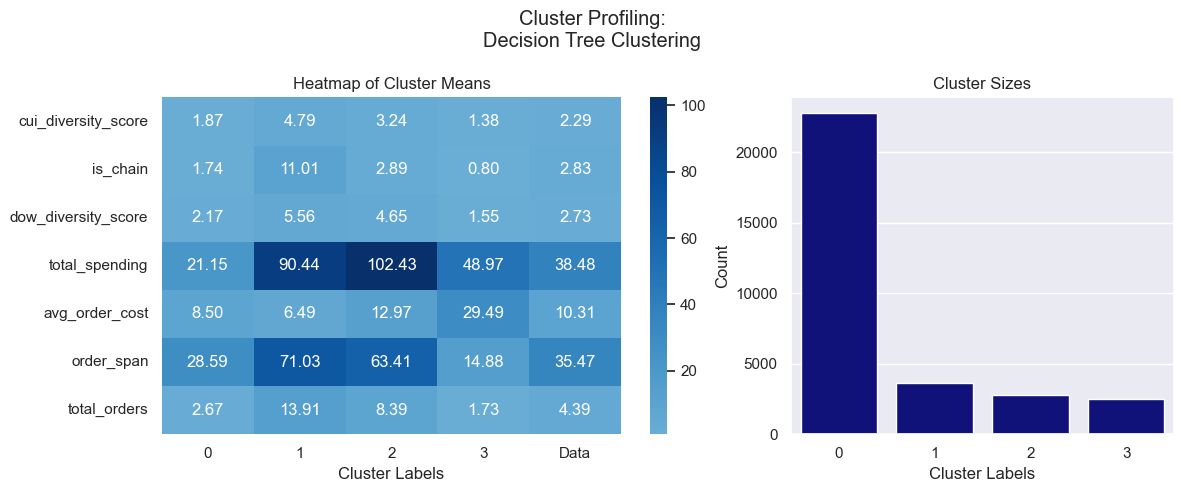

In [245]:
dt_profile = df.groupby('merged_labels')[features].mean().T

# Calculate global means for comparison (optional)
df_means = df[features].mean()
df_means.name = "Data"
dt_profile = pd.concat([dt_profile, df_means], axis=1)

# Set up the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[0.6, 0.4], tight_layout=True)

# Heatmap for cluster means
sns.heatmap(dt_profile,
            center=0, annot=True, cmap="Blues", fmt=".2f",
            ax=axes[0])
axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Bar plot for cluster sizes
sns.countplot(data=df, x='merged_labels', ax=axes[1], palette=["darkblue"])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")
axes[1].set_ylabel("Count")

# Set an overall title for the figure
fig.suptitle("Cluster Profiling:\nDecision Tree Clustering")
plt.show()


### Comparing categorical features in each cluster

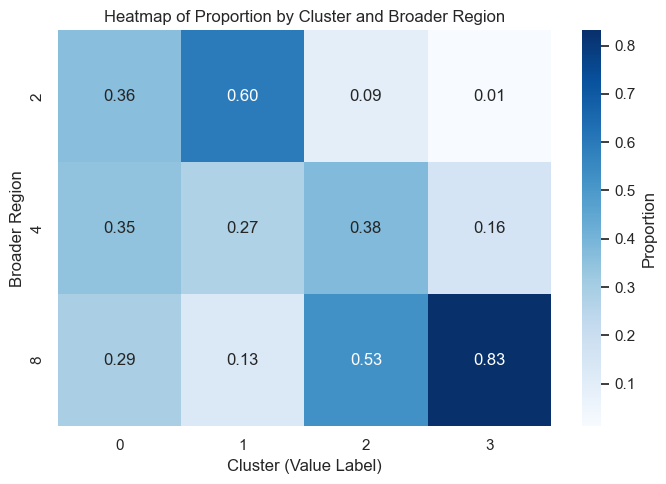

In [246]:
# Calculate the proportions
proportions = (
    df.groupby(['broader_region', 'merged_labels'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=0)
)

# Plot the heat map
plt.figure(figsize=(7, 5))
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Proportion'})
plt.title("Heatmap of Proportion by Cluster and Broader Region")
plt.xlabel("Cluster (Value Label)")
plt.ylabel("Broader Region")
plt.tight_layout()
plt.show()


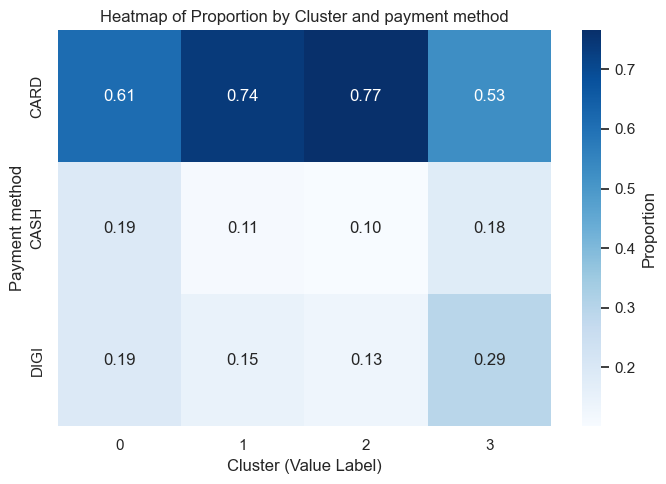

In [247]:
# Calculate the proportions
proportions = (
    df.groupby(['payment_method', 'merged_labels'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=0)
)

# Plot the heat map
plt.figure(figsize=(7, 5))
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Proportion'})
plt.title("Heatmap of Proportion by Cluster and payment method")
plt.xlabel("Cluster (Value Label)")
plt.ylabel("Payment method")
plt.tight_layout()
plt.show()

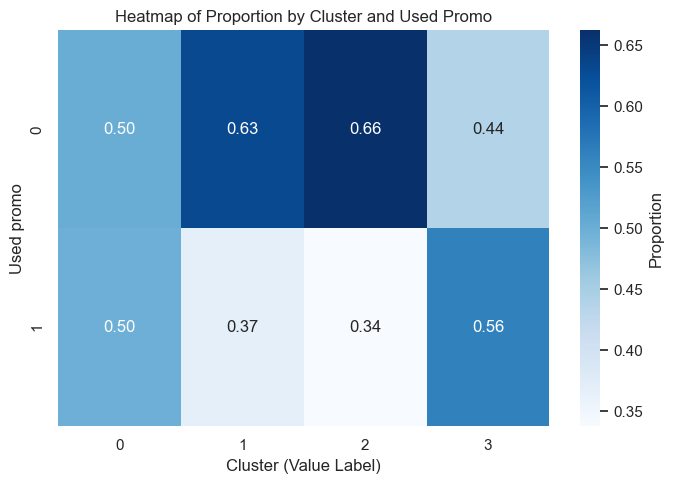

In [248]:
proportions = (
    df.groupby(['used_promo', 'merged_labels'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=0)
)

# Plot the heat map
plt.figure(figsize=(7, 5))
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Proportion'})
plt.title("Heatmap of Proportion by Cluster and Used Promo")
plt.xlabel("Cluster (Value Label)")
plt.ylabel("Used promo")
plt.tight_layout()
plt.show()

### Diversity scores in each cluster

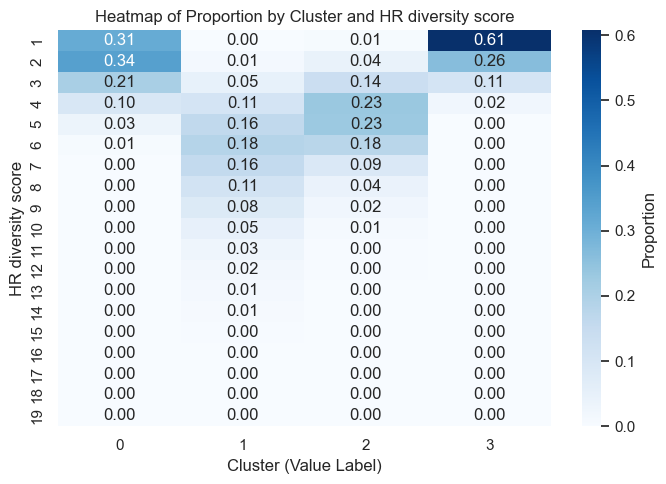

In [249]:
#This code was generated with the help of ChatGPT
proportions = (
    df.groupby(['hr_diversity_score', 'merged_labels'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=0)
)

plt.figure(figsize=(7, 5))
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Proportion'})
plt.title("Heatmap of Proportion by Cluster and HR diversity score")
plt.xlabel("Cluster (Value Label)")
plt.ylabel("HR diversity score")
plt.tight_layout()
plt.show()


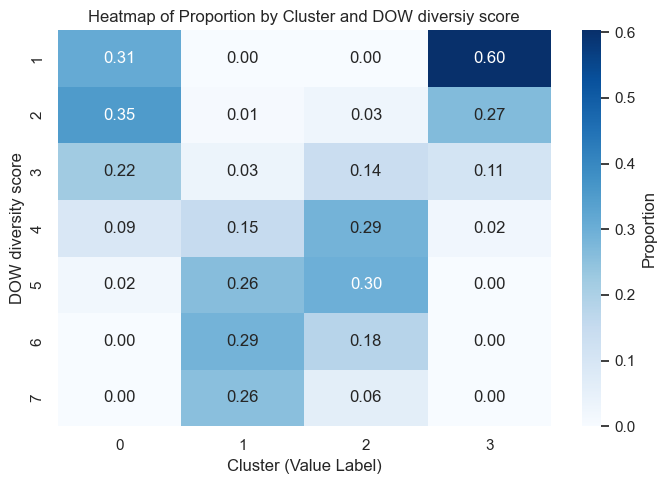

In [250]:
#This code was generated with the help of ChatGPT

#  Calculate the proportions
proportions = (
    df.groupby(['dow_diversity_score', 'merged_labels'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=0)
)

# Plot the heat map
plt.figure(figsize=(7, 5))
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Proportion'})
plt.title("Heatmap of Proportion by Cluster and DOW diversiy score")
plt.xlabel("Cluster (Value Label)")
plt.ylabel("DOW diversity score")
plt.tight_layout()
plt.show()

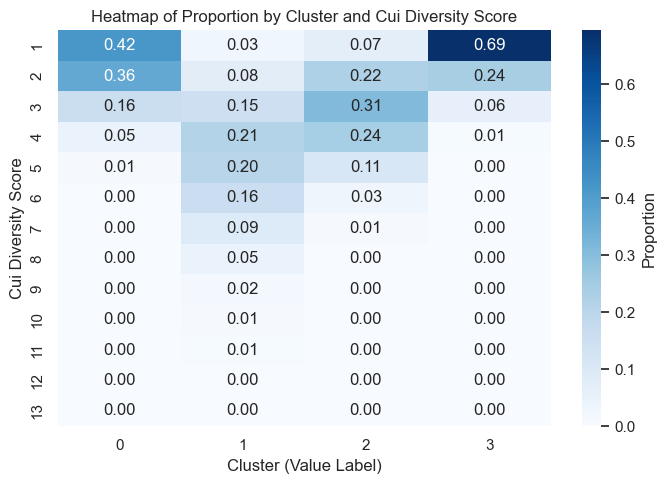

In [251]:
#This code was generated with the help of ChatGPT

# Calculate the proportions
proportions = (
    df.groupby(['cui_diversity_score', 'merged_labels'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=0)
)

# Plot the heat map
plt.figure(figsize=(7, 5))
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Proportion'})
plt.title("Heatmap of Proportion by Cluster and Cui Diversity Score")
plt.xlabel("Cluster (Value Label)")
plt.ylabel("Cui Diversity Score")
plt.tight_layout()
plt.show()

### Comparing time features for each cluster

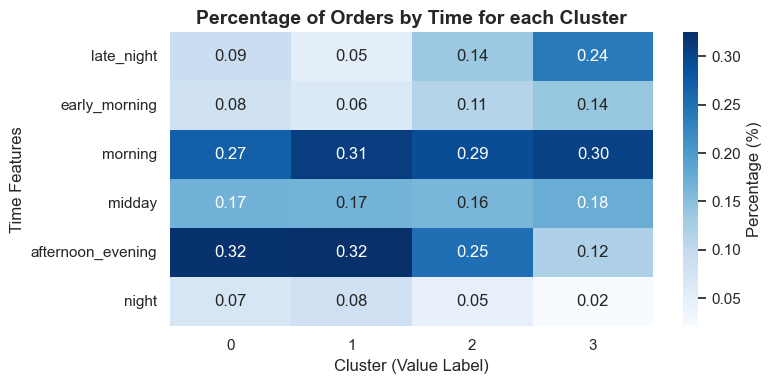

In [252]:
time_features = ['late_night', 'early_morning', 'morning', 'midday',
                 'afternoon_evening', 'night']

# Calculate the means grouped by clusters
means = df.groupby('merged_labels')[time_features].mean()

# Convert to percentages
percentages = (means.T / means.sum(axis=1))

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(percentages, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
plt.title("Percentage of Orders by Time for each Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Cluster (Value Label)", fontsize=12)
plt.ylabel("Time Features", fontsize=12)
plt.tight_layout()
plt.show()

In [253]:
df['early_morning2']= df[['HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14']].sum(axis=1)
df['afternoon_evening2']= df[['HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21']].sum(axis=1)
df['after_hours2']= df[['HR_22', 'HR_23', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7']].sum(axis=1)

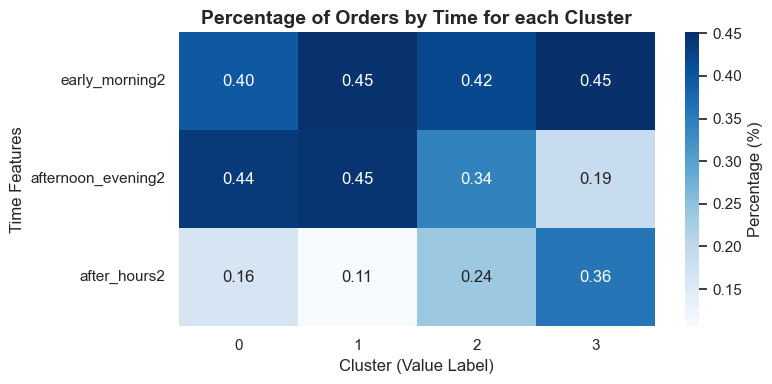

In [254]:
time_features2 = ['early_morning2',
       'afternoon_evening2', 'after_hours2']

# Calculate the means grouped by clusters
means = df.groupby('merged_labels')[time_features2].mean()

# Convert to percentages
percentages = (means.T / means.sum(axis=1))

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(percentages, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
plt.title("Percentage of Orders by Time for each Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Cluster (Value Label)", fontsize=12)
plt.ylabel("Time Features", fontsize=12)
plt.tight_layout()
plt.show()

In [255]:
dow_columns = [col for col in df.columns if col.startswith("DOW_")]


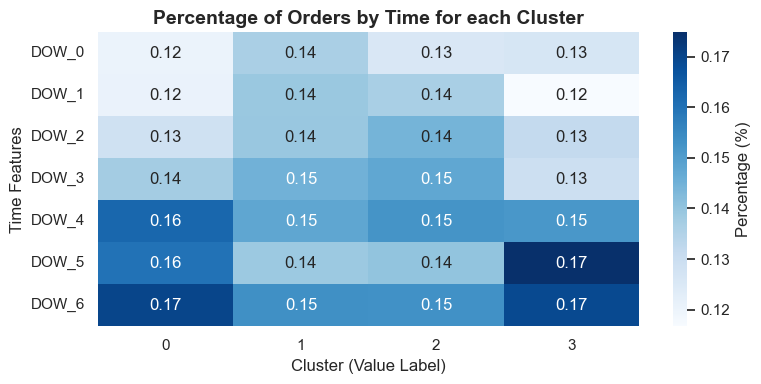

In [256]:
means = df.groupby('merged_labels')[dow_columns].mean()

# Convert to percentages
percentages = (means.T / means.sum(axis=1))

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(percentages, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
plt.title("Percentage of Orders by Time for each Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Cluster (Value Label)", fontsize=12)
plt.ylabel("Time Features", fontsize=12)
plt.tight_layout()
plt.show()

### Order span and first order for each cluster

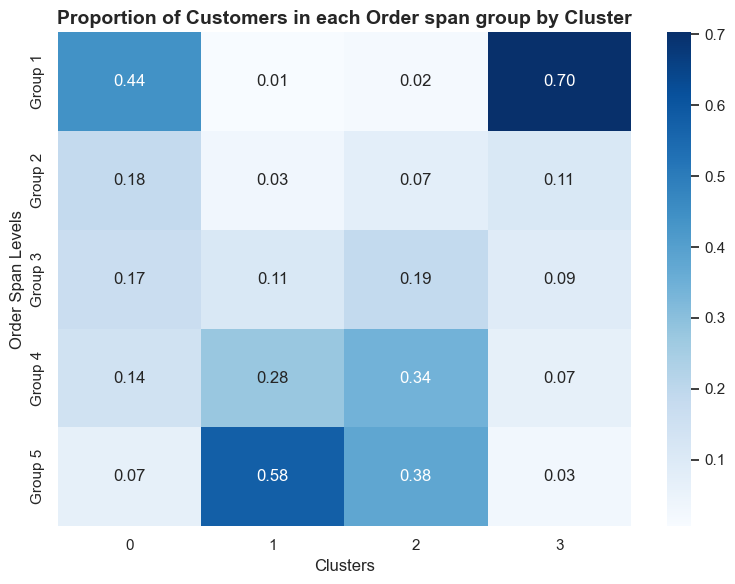

In [257]:
df_visual = df.copy()

df_visual['order_span_binned'] = pd.cut(df_visual['order_span'], bins=5, labels=[f"Group {i}" for i in range(1, 6)])

binned_means = (
    df_visual.groupby(['order_span_binned', 'merged_labels'])['order_span']
    .size()
    .unstack(fill_value=0) 
    .apply(lambda x: x / x.sum(), axis=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(binned_means, annot=True, fmt=".2f", cmap="Blues")
plt.title("Proportion of Customers in each Order span group by Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Order Span Levels", fontsize=12)
plt.tight_layout()
plt.show()

In [258]:
# Use pd.cut with retbins=True to see the bin edges
df_visual['first_order_binned'], bin_edges = pd.cut(
    df_visual['first_order'], 
    bins=5, 
    labels=[f"Group {i}" for i in range(1, 6)], 
    retbins=True
)

# Print the bin edges
print("Bin Edges for 'first_order':", bin_edges)

Bin Edges for 'first_order': [-0.09 18.   36.   54.   72.   90.  ]


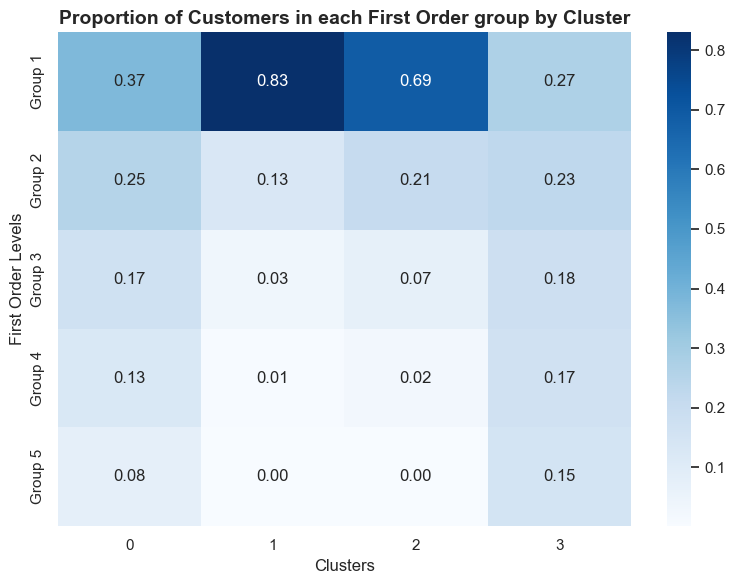

In [259]:
df_visual['first_order_binned'] = pd.cut(df_visual['first_order'], bins=5, labels=[f"Group {i}" for i in range(1, 6)])

binned_means = (
    df_visual.groupby(['first_order_binned', 'merged_labels'])['first_order']
    .size()
    .unstack(fill_value=0) 
    .apply(lambda x: x / x.sum(), axis=0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(binned_means, annot=True, fmt=".2f", cmap="Blues")
plt.title("Proportion of Customers in each First Order group by Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("First Order Levels", fontsize=12)
plt.tight_layout()
plt.show()

In [260]:
df_visual['first_order_binned'] 

customer_id
1b8f824d5e    Group 1
5d272b9dcb    Group 1
f6d1b2ba63    Group 1
180c632ed8    Group 1
4eb37a6705    Group 1
               ...   
c80631c1a4    Group 4
4735d7d1ef    Group 4
7ed46af927    Group 4
f6308403d1    Group 4
6abcefede6    Group 5
Name: first_order_binned, Length: 31672, dtype: category
Categories (5, object): ['Group 1' < 'Group 2' < 'Group 3' < 'Group 4' < 'Group 5']

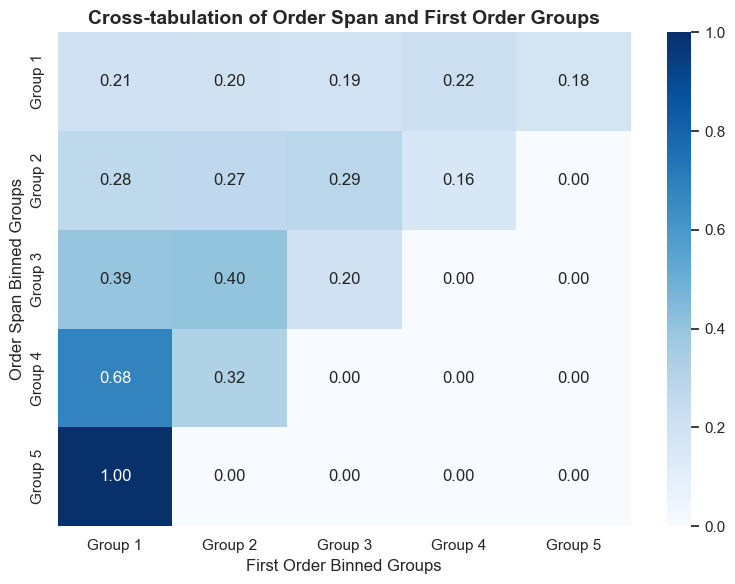

In [261]:
# Create a cross-tabulation of the two binned features
crosstab = pd.crosstab(
    df_visual['order_span_binned'],
    df_visual['first_order_binned'],
    normalize='index'  # Optionally normalize by row
)

# Display the crosstab as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt=".2f", cmap="Blues")
plt.title("Cross-tabulation of Order Span and First Order Groups", fontsize=14, fontweight='bold')
plt.xlabel("First Order Binned Groups", fontsize=12)
plt.ylabel("Order Span Binned Groups", fontsize=12)
plt.tight_layout()
plt.show()


In [262]:
# Create a cross-tabulation with counts for each cluster in each combination of groups
cluster_cross_counts = (
    df_visual.groupby(['order_span_binned', 'first_order_binned', 'merged_labels'])
    .size()
    .unstack(fill_value=0)  # Unstack to create a separate column for each cluster
)

In [263]:
# Define a list of specific group pairs
specific_groups = [
    ('Group 5', 'Group 1'),
    ('Group 4', 'Group 1'),
    ('Group 4', 'Group 2'),
    ('Group 3', 'Group 1'),
    ('Group 3', 'Group 2'),
    ('Group 3', 'Group 3'),
    ('Group 2', 'Group 1'),
    ('Group 2', 'Group 2'),
    ('Group 2', 'Group 3'),
    ('Group 2', 'Group 4'),
    ('Group 1', 'Group 1'),
    ('Group 1', 'Group 2'),
    ('Group 1', 'Group 3'),
    ('Group 1', 'Group 4'),
    ('Group 1', 'Group 5'),

]

# Create a list to store the counts for each pair
specific_group_counts = []

# Iterate through the list of specific groups and extract counts
for order_group, first_order_group in specific_groups:
    counts = cluster_cross_counts.loc[order_group, first_order_group]
    specific_group_counts.append((order_group, first_order_group, counts))

# Print the results
for order_group, first_order_group, counts in specific_group_counts:
    print(f"Counts for Order Span: {order_group} and First Order: {first_order_group}")
    print(counts)
    print("-" * 50)


Counts for Order Span: Group 5 and First Order: Group 1
merged_labels
0    1514
1    2094
2    1065
3      71
Name: (Group 5, Group 1), dtype: int64
--------------------------------------------------
Counts for Order Span: Group 4 and First Order: Group 1
merged_labels
0    2201
1     720
2     634
3     112
Name: (Group 4, Group 1), dtype: int64
--------------------------------------------------
Counts for Order Span: Group 4 and First Order: Group 2
merged_labels
0    1045
1     281
2     325
3      52
Name: (Group 4, Group 2), dtype: int64
--------------------------------------------------
Counts for Order Span: Group 3 and First Order: Group 1
merged_labels
0    1542
1     158
2     182
3      81
Name: (Group 3, Group 1), dtype: int64
--------------------------------------------------
Counts for Order Span: Group 3 and First Order: Group 2
merged_labels
0    1540
1     153
2     214
3     101
Name: (Group 3, Group 2), dtype: int64
--------------------------------------------------


In [264]:
# Normalize cluster counts column-wise to calculate percentages for each cluster
cluster_cross_percents = (
    cluster_cross_counts.div(cluster_cross_counts.sum(axis=0), axis=1) * 100  # Normalize columns to get percentages
)

# Define a list of specific group pairs
specific_groups = [
    ('Group 5', 'Group 1'),
    ('Group 4', 'Group 1'),
    ('Group 4', 'Group 2'),
    ('Group 3', 'Group 1'),
    ('Group 3', 'Group 2'),
    ('Group 3', 'Group 3'),
    ('Group 2', 'Group 1'),
    ('Group 2', 'Group 2'),
    ('Group 2', 'Group 3'),
    ('Group 2', 'Group 4'),
    ('Group 1', 'Group 1'),
    ('Group 1', 'Group 2'),
    ('Group 1', 'Group 3'),
    ('Group 1', 'Group 4'),
    ('Group 1', 'Group 5'),
]

# Create a list to store the percentages for each pair
specific_group_percents = []

# Iterate through the list of specific groups and extract percentages
for order_group, first_order_group in specific_groups:
    percents = cluster_cross_percents.loc[order_group, first_order_group]
    specific_group_percents.append((order_group, first_order_group, percents))

# Print the results
for order_group, first_order_group, percents in specific_group_percents:
    print(f"Percentages for Order Span: {order_group} and First Order: {first_order_group}")
    print(percents.round(2))  # Round to 2 decimal places for readability
    print("-" * 50)


Percentages for Order Span: Group 5 and First Order: Group 1
merged_labels
0     6.65
1    57.67
2    37.93
3     2.87
Name: (Group 5, Group 1), dtype: float64
--------------------------------------------------
Percentages for Order Span: Group 4 and First Order: Group 1
merged_labels
0     9.67
1    19.83
2    22.58
3     4.52
Name: (Group 4, Group 1), dtype: float64
--------------------------------------------------
Percentages for Order Span: Group 4 and First Order: Group 2
merged_labels
0     4.59
1     7.74
2    11.57
3     2.10
Name: (Group 4, Group 2), dtype: float64
--------------------------------------------------
Percentages for Order Span: Group 3 and First Order: Group 1
merged_labels
0    6.78
1    4.35
2    6.48
3    3.27
Name: (Group 3, Group 1), dtype: float64
--------------------------------------------------
Percentages for Order Span: Group 3 and First Order: Group 2
merged_labels
0    6.77
1    4.21
2    7.62
3    4.08
Name: (Group 3, Group 2), dtype: float64
----

In [265]:
df_visual[df_visual['merged_labels']==0].groupby(['first_order_binned'])['avg_order_cost'].describe()

count      mean       std   min       25%    50%  \
first_order_binned                                                      
Group 1             8507.0  8.022837  4.373317  0.66  4.500000  7.275   
Group 2             5714.0  8.288183  4.575785  0.37  4.620000  7.410   
Group 3             3884.0  8.828554  4.637446  0.42  5.379375  8.085   
Group 4             2873.0  9.120980  4.815511  0.60  5.435000  8.365   
Group 5             1777.0  9.700571  5.212785  0.41  5.800000  8.850   

                          75%    max  
first_order_binned                    
Group 1             10.728333  20.77  
Group 2             11.284375  20.81  
Group 3             12.037500  20.88  
Group 4             12.300000  20.86  
Group 5             13.120000  20.73

In [266]:
df_visual[df_visual['merged_labels']==0].groupby(['first_order_binned', 'order_span_binned'])['total_orders'].describe()

count      mean       std  min  25%  \
first_order_binned order_span_binned                                         
Group 1            Group 1            2093.0  1.645963  0.855378  1.0  1.0   
                   Group 2            1157.0  2.972342  1.063354  2.0  2.0   
                   Group 3            1542.0  3.435798  1.197863  2.0  2.0   
                   Group 4            2201.0  3.830077  1.282832  2.0  3.0   
                   Group 5            1514.0  4.159841  1.290393  2.0  3.0   
Group 2            Group 1            1971.0  1.641299  0.836781  1.0  1.0   
                   Group 2            1158.0  2.896373  0.997648  2.0  2.0   
                   Group 3            1540.0  3.453896  1.214416  2.0  2.0   
                   Group 4            1045.0  3.799043  1.308607  2.0  3.0   
Group 3            Group 1            1928.0  1.659232  0.853308  1.0  1.0   
                   Group 2            1221.0  3.019656  1.105696  2.0  2.0   
                   Group 3             735.0  3.451701  1.209654  2.0  3.0   
Group 4            Group 1            2239.0  1.716838  0.918598  1.0  1.0   
                   Group 2             634.0  3.078864  1.132639  2.0  2.0   
Group 5            Group 1            1777.0  1.494091  0.828880  1.0  1.0   

                                      50%  75%  max  
first_order_binned order_span_binned                 
Group 1            Group 1            1.0  2.0  6.0  
                   Group 2            3.0  4.0  6.0  
                   Group 3            3.0  4.0  6.0  
                   Group 4            4.0  5.0  6.0  
                   Group 5            4.0  5.0  6.0  
Group 2            Group 1            1.0  2.0  6.0  
                   Group 2            3.0  3.0  6.0  
                   Group 3            3.0  4.0  6.0  
                   Group 4            4.0  5.0  6.0  
Group 3            Group 1            1.0  2.0  6.0  
                   Group 2            3.0  4.0  6.0  
                   Group 3            3.0  4.0  6.0  
Group 4            Group 1            1.0  2.0  6.0  
                   Group 2            3.0  4.0  6.0  
Group 5            Group 1            1.0  2.0  6.0

In [267]:
df_visual[df_visual['merged_labels']==0].groupby(['first_order_binned', 'order_span_binned'])['used_promo'].value_counts(normalize=True)

first_order_binned  order_span_binned  used_promo
Group 1             Group 1            1             0.623507
                                       0             0.376493
                    Group 2            0             0.590320
                                       1             0.409680
                    Group 3            0             0.591440
                                       1             0.408560
                    Group 4            0             0.590186
                                       1             0.409814
                    Group 5            0             0.589828
                                       1             0.410172
Group 2             Group 1            1             0.612887
                                       0             0.387113
                    Group 2            0             0.605354
                                       1             0.394646
                    Group 3            0             0.596104
                    

In [268]:
df_visual[df_visual['merged_labels']==0].groupby(['first_order_binned'])['used_promo'].value_counts(normalize=True)

first_order_binned  used_promo
Group 1             0             0.537792
                    1             0.462208
Group 2             0             0.526601
                    1             0.473399
Group 3             1             0.506437
                    0             0.493563
Group 4             1             0.554473
                    0             0.445527
Group 5             1             0.636466
                    0             0.363534
Name: proportion, dtype: float64

In [269]:
df_visual[df_visual['merged_labels']==0].groupby(['order_span_binned'])['used_promo'].value_counts(normalize=True)

order_span_binned  used_promo
Group 1            1             0.613909
                   0             0.386091
Group 2            0             0.593046
                   1             0.406954
Group 3            0             0.594970
                   1             0.405030
Group 4            0             0.593346
                   1             0.406654
Group 5            0             0.589828
                   1             0.410172
Name: proportion, dtype: float64

In [270]:
df_visual[df_visual['merged_labels']==0].groupby(['order_span_binned'])['used_promo'].value_counts(normalize=True)

order_span_binned  used_promo
Group 1            1             0.613909
                   0             0.386091
Group 2            0             0.593046
                   1             0.406954
Group 3            0             0.594970
                   1             0.405030
Group 4            0             0.593346
                   1             0.406654
Group 5            0             0.589828
                   1             0.410172
Name: proportion, dtype: float64

In [271]:
df_visual[df_visual['merged_labels']==0].groupby(['broader_region'])['used_promo'].value_counts(normalize=True)

broader_region  used_promo
2               1             0.528915
                0             0.471085
4               0             0.567298
                1             0.432702
8               1             0.537241
                0             0.462759
Name: proportion, dtype: float64

In [272]:
df_visual[df_visual['merged_labels']==3].groupby(['first_order_binned', 'order_span_binned'])['used_promo'].value_counts(normalize=True)

first_order_binned  order_span_binned  used_promo
Group 1             Group 1            1             0.652439
                                       0             0.347561
                    Group 2            0             0.626506
                                       1             0.373494
                    Group 3            0             0.679012
                                       1             0.320988
                    Group 4            0             0.714286
                                       1             0.285714
                    Group 5            0             0.633803
                                       1             0.366197
Group 2             Group 1            1             0.643917
                                       0             0.356083
                    Group 2            0             0.614286
                                       1             0.385714
                    Group 3            0             0.603960
                    

In [273]:
df_visual[df_visual['merged_labels']==3].groupby(['order_span_binned'])['used_promo'].value_counts(normalize=True)

order_span_binned  used_promo
Group 1            1             0.653846
                   0             0.346154
Group 2            0             0.643382
                   1             0.356618
Group 3            0             0.650655
                   1             0.349345
Group 4            0             0.707317
                   1             0.292683
Group 5            0             0.633803
                   1             0.366197
Name: proportion, dtype: float64

Customers from cluster 0 are in the higher groups for order_span and in the lowest groups for first order. This means that this are very loyal and old customers that we need to keep in our business.

Customers from cluster 1 are in the higher groups for order_span and as well in the lowest groups for first order. They are loyal and old customers, we need to keep the in the business, but they are a litle less loyals than the ones from cluster 0.

Customers from cluster 2 have a very low order span, but have first order values very well spred across the groups. Most customers from cluster 2 are in the group 1 for order span. We have almost 5 thousand customers from that cluster that are recent customers, but most of th customers in these clusters are older customers that have a very low order span, meaning they did not stayed in the bussiness for long.

In cluster 3 we have mostly loyal customers, but some of them have as well a very low order span, even though this is a very small part of the cluster. They have been in the business for long.

### Broader region segmentation for each cluster

In [274]:
def calculate_favourite_cuisine_proportion(row):

    favourite_cuisine_spending = row[cuisine_columns].max()
   
    return favourite_cuisine_spending / row['total_spending']

df['favourite_cuisine_proportion'] = df.apply(calculate_favourite_cuisine_proportion, axis=1)

#### Cluster 0

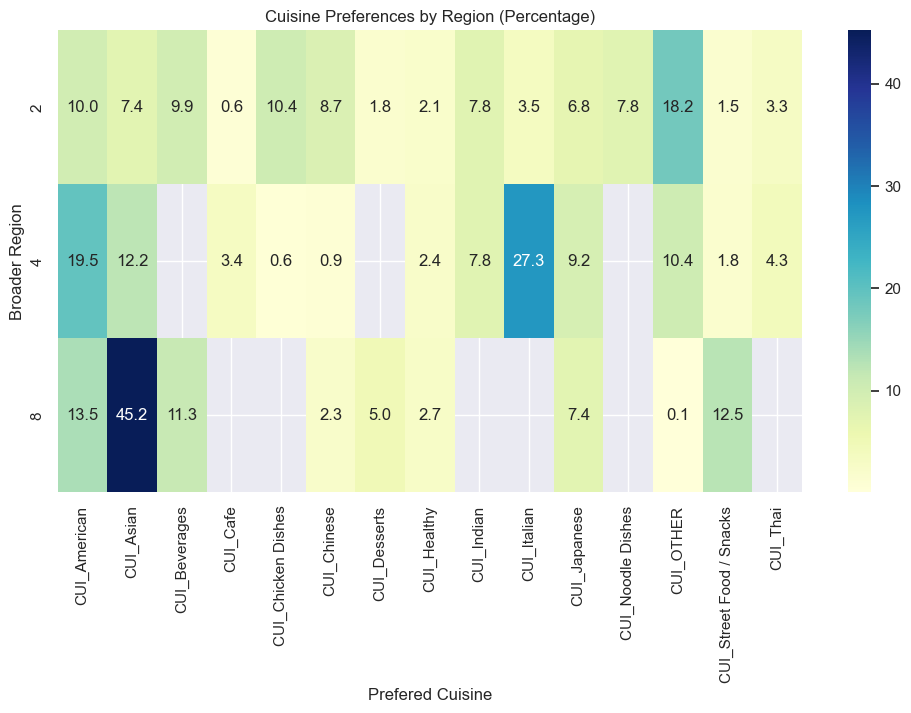

In [275]:
pivot_table_percentage = filtered_df_0.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    aggfunc='size',
)

pivot_table_percentage = pivot_table_percentage.div(pivot_table_percentage.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_percentage, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Cuisine Preferences by Region (Percentage)")
plt.xlabel("Prefered Cuisine")
plt.ylabel("Broader Region")
plt.show()


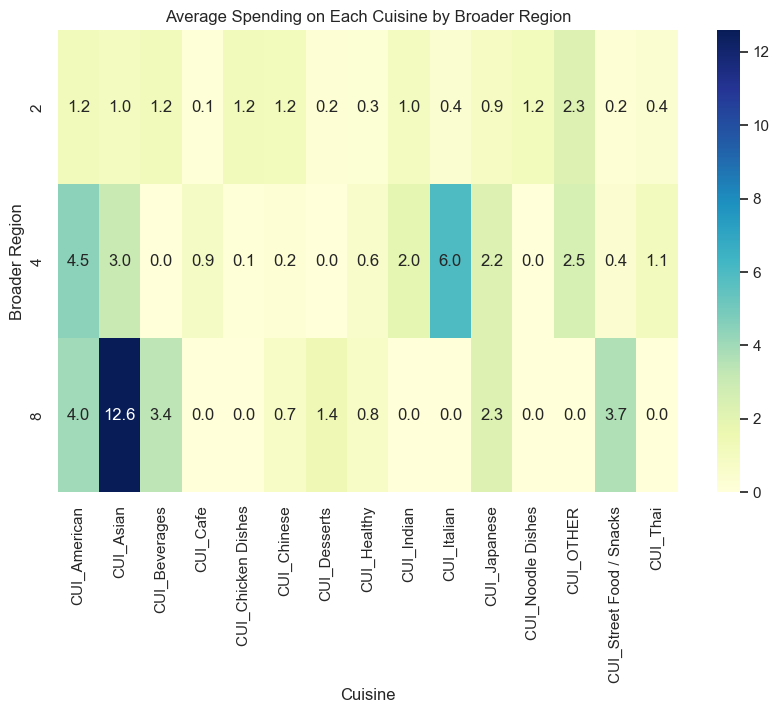

In [276]:
avg_spending_by_region = filtered_df_0.groupby('broader_region')[cuisine_columns].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(avg_spending_by_region, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending on Each Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


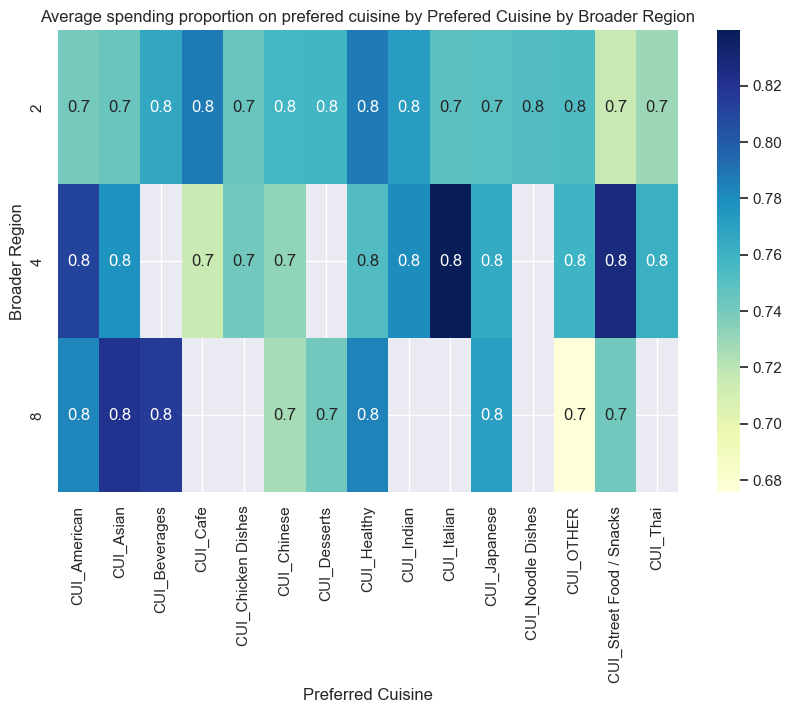

In [277]:
pivot_table_avg_spending = filtered_df_0.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='favourite_cuisine_proportion',
    aggfunc='mean',
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average spending proportion on prefered cuisine by Prefered Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


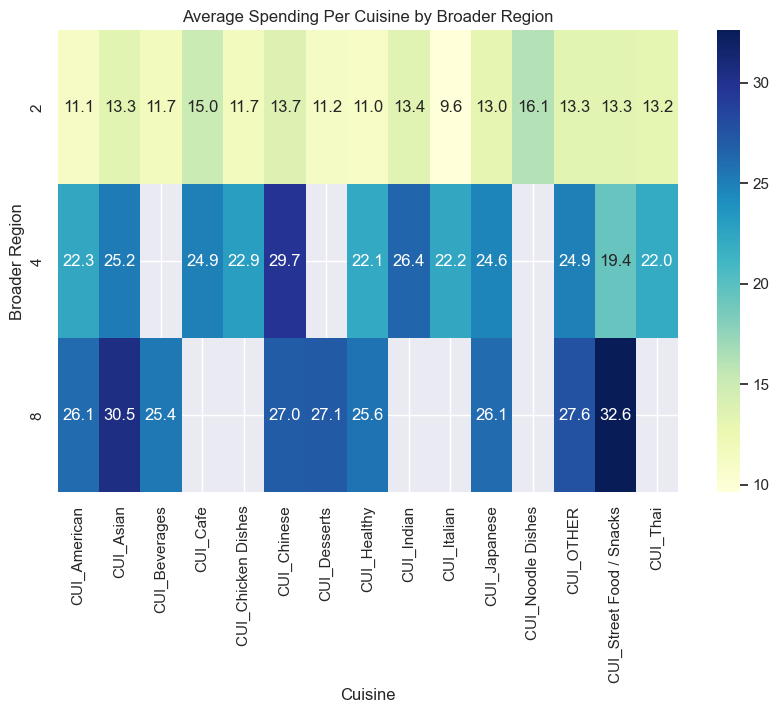

In [278]:
pivot_table_avg_spending = filtered_df_0.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='total_spending',
    aggfunc='mean',  # Calculate the average spending
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending Per Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


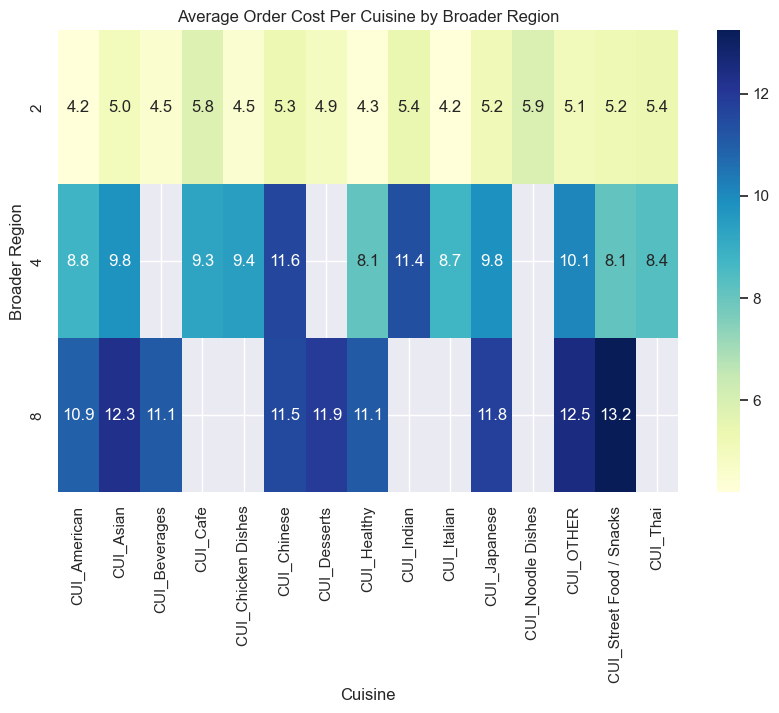

In [279]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_0.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='avg_order_cost',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Order Cost Per Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


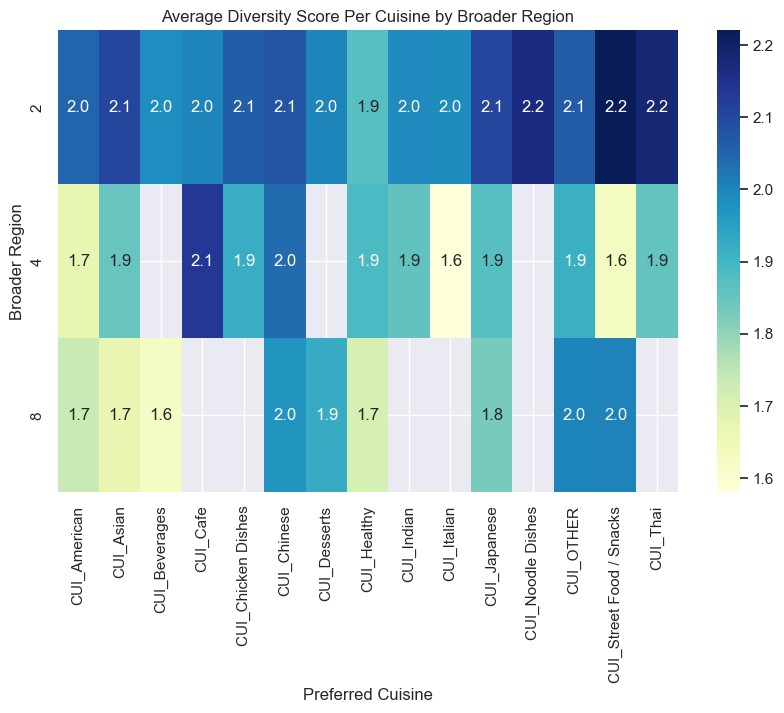

In [280]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_0.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='cui_diversity_score',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Diversity Score Per Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()

In [281]:
filtered_df_0.groupby('broader_region').value_counts()

broader_region  customer_region  customer_age  vendor_count  product_count  is_chain  first_order  last_order  last_promo  payment_method  CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  CUI_Street Food / Snacks  CUI_Thai  DOW_0  DOW_1  DOW_2  DOW_3  DOW_4  DOW_5  DOW_6  HR_0  HR_1  HR_2  HR_3  HR_4  HR_5  HR_6  HR_7  HR_8  HR_9  HR_10  HR_11  HR_12  HR_13  HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  late_night  early_morning  morning  midday  afternoon_evening  night  weekday  weekend  total_spending  total_orders  used_promo  order_frequency  order_span  avg_product_cost  avg_order_cost  products_per_vendor  cui_diversity_score  prefered_cuisine  dow_diversity_score  hr_diversity_score  merged_labels  favourite_cuisine_proportion
2               2360             15.0          1             3              3         11.0         44

The segmentation by broader region, as stated in the EDA should be taken into consideration, specially considering we have very low engaged customers in this cluster. Divind the cluster according to broader regions is a good solution to develop more targeted marketing strategies.

#### Cluster 1

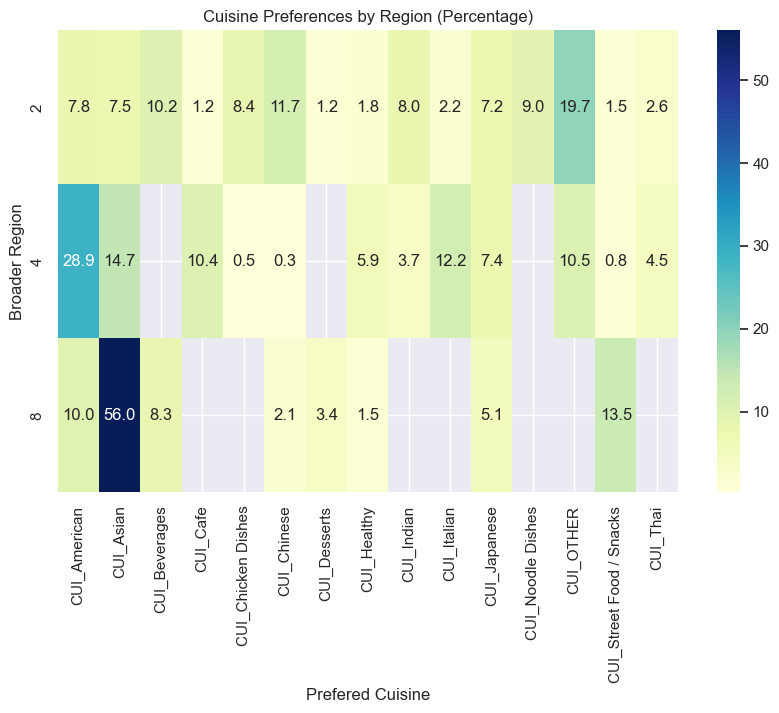

In [282]:
pivot_table_percentage = filtered_df_1.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    aggfunc='size',
)


pivot_table_percentage = pivot_table_percentage.div(pivot_table_percentage.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_percentage, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Cuisine Preferences by Region (Percentage)")
plt.xlabel("Prefered Cuisine")
plt.ylabel("Broader Region")
plt.show()


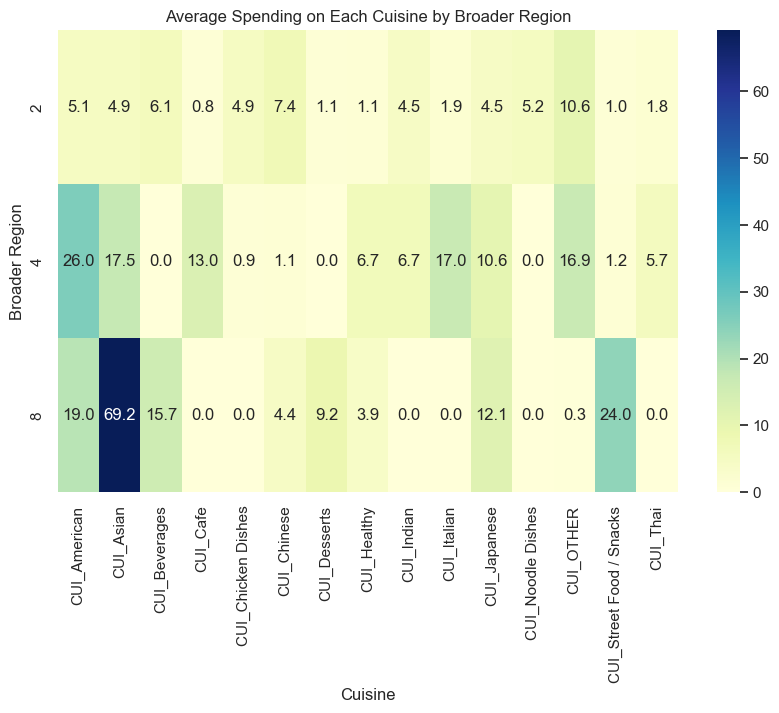

In [283]:
avg_spending_by_region = filtered_df_1.groupby('broader_region')[cuisine_columns].mean()

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(avg_spending_by_region, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending on Each Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


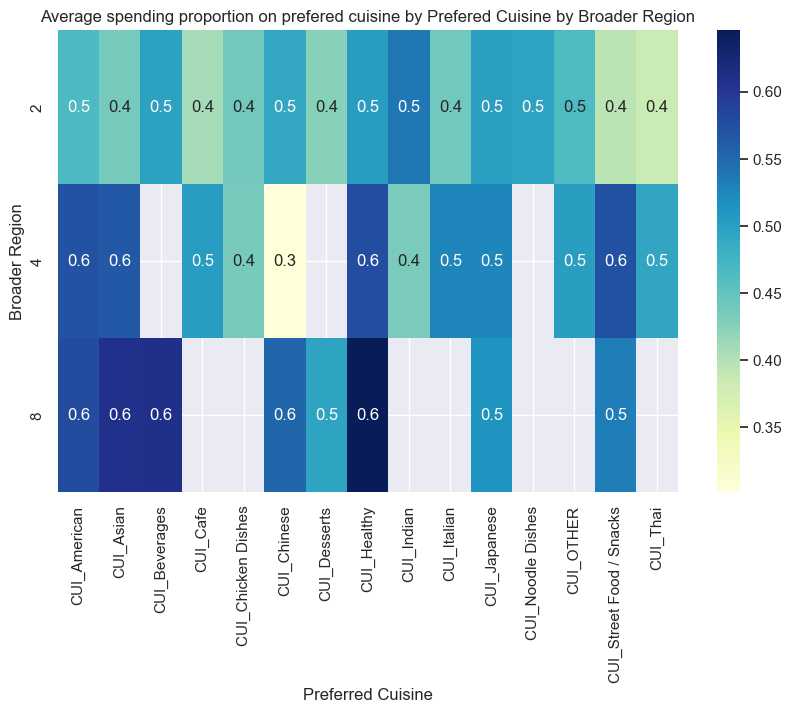

In [284]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_1.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='favourite_cuisine_proportion',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average spending proportion on prefered cuisine by Prefered Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


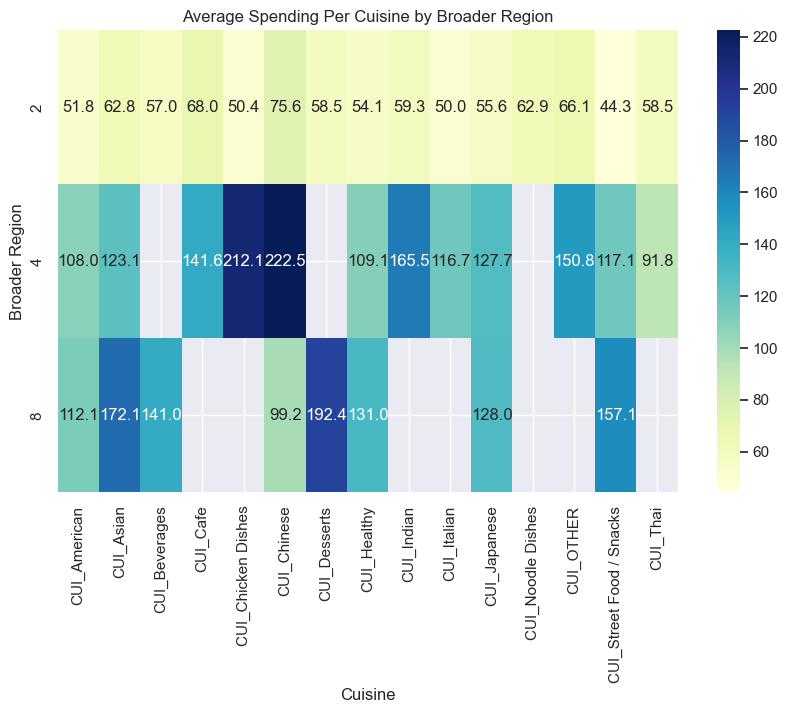

In [285]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_1.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='total_spending',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending Per Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


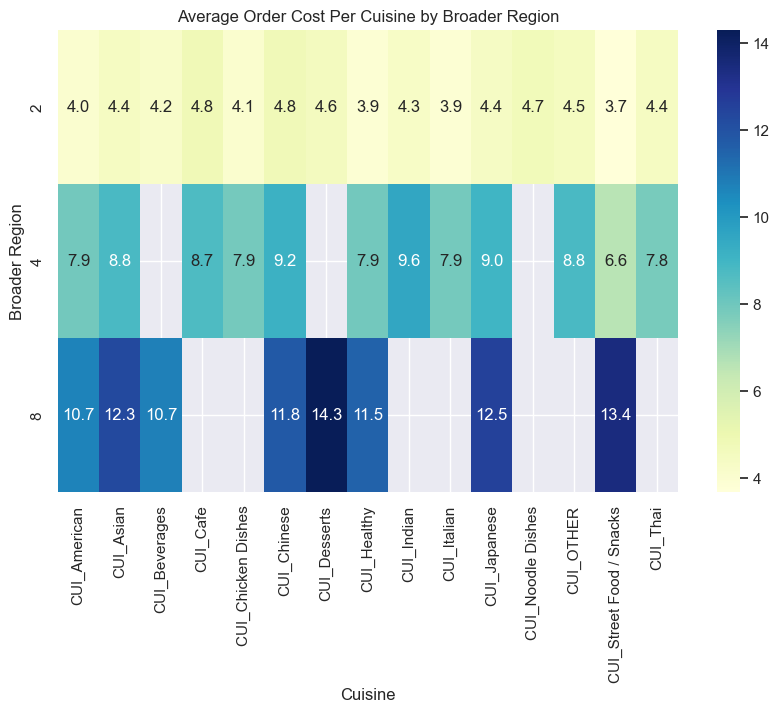

In [286]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_1.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='avg_order_cost',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Order Cost Per Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


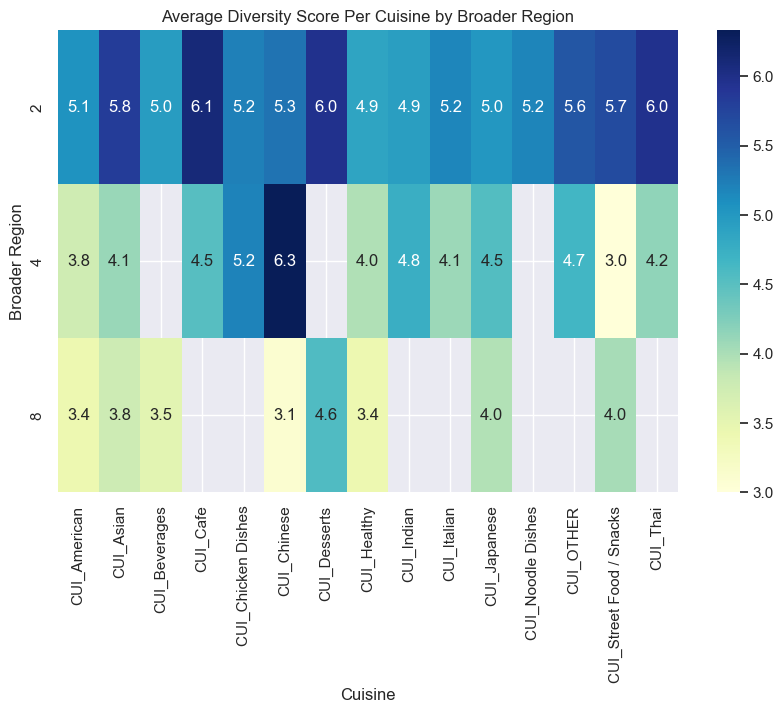

In [287]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_1.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='cui_diversity_score',
    aggfunc='mean',  # Calculate the average spending

)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Diversity Score Per Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


#### Cluster 2

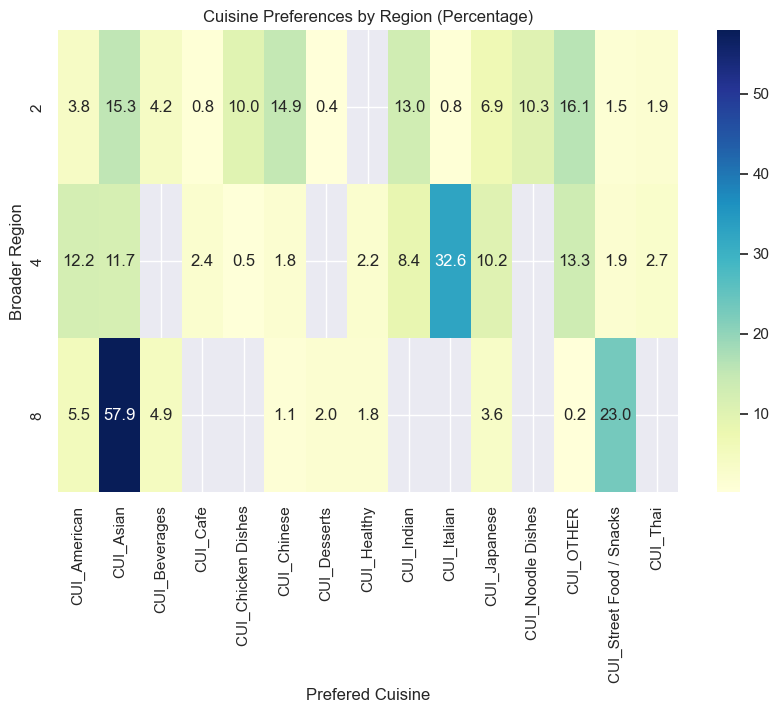

In [288]:
pivot_table_percentage = filtered_df_2.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    aggfunc='size'
)

# Convert counts to percentages
pivot_table_percentage = pivot_table_percentage.div(pivot_table_percentage.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_percentage, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Cuisine Preferences by Region (Percentage)")
plt.xlabel("Prefered Cuisine")
plt.ylabel("Broader Region")
plt.show()


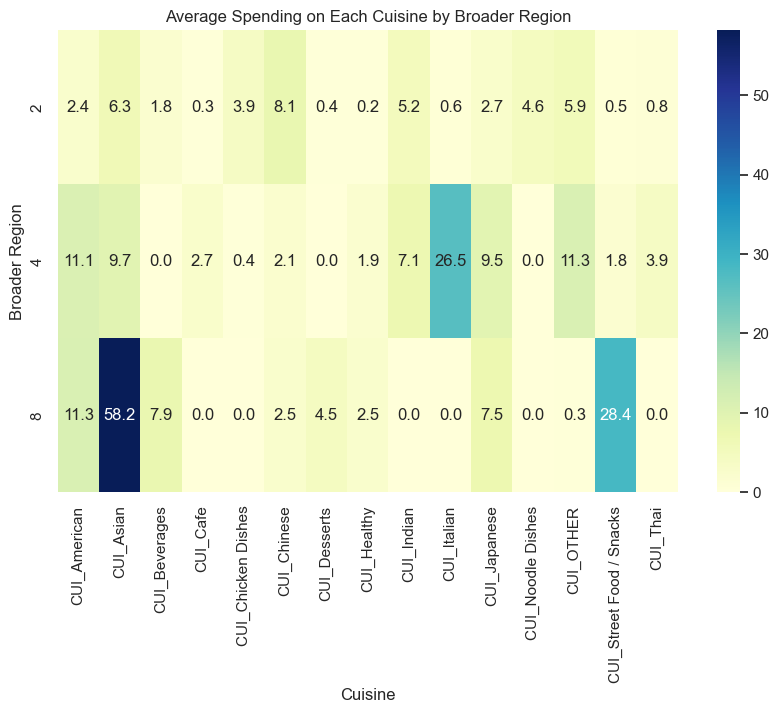

In [289]:
avg_spending_by_region = filtered_df_2.groupby('broader_region')[cuisine_columns].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(avg_spending_by_region, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending on Each Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


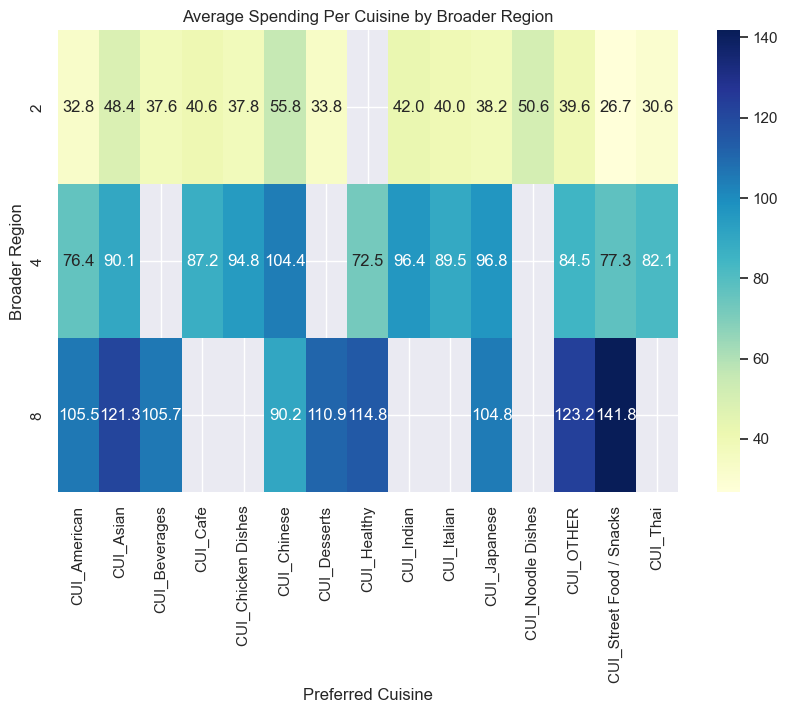

In [290]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_2.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='total_spending',
    aggfunc='mean',  # Calculate the average spending

)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending Per Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


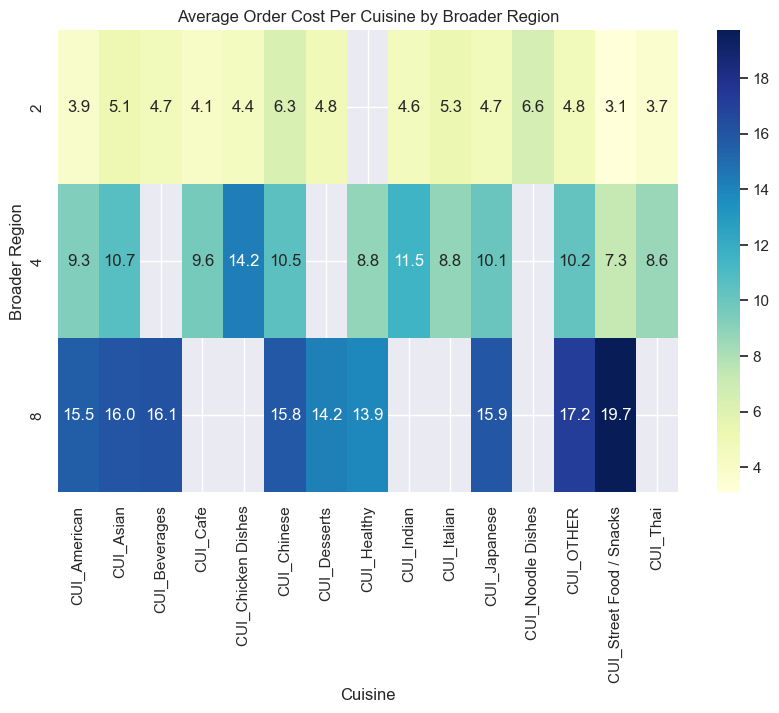

In [291]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_2.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='avg_order_cost',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Order Cost Per Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


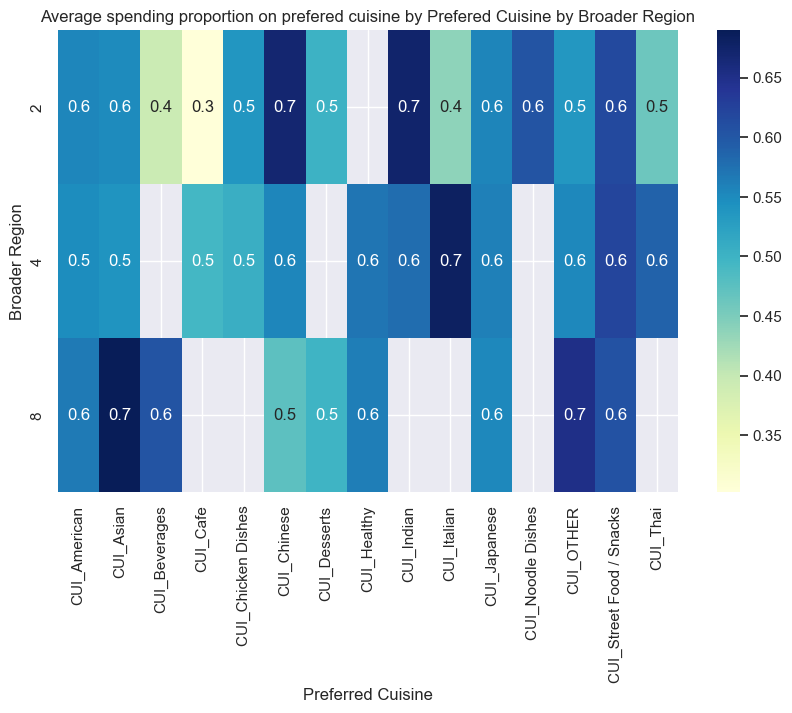

In [292]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_2.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='favourite_cuisine_proportion',
    aggfunc='mean',  # Calculate the average spending

)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average spending proportion on prefered cuisine by Prefered Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


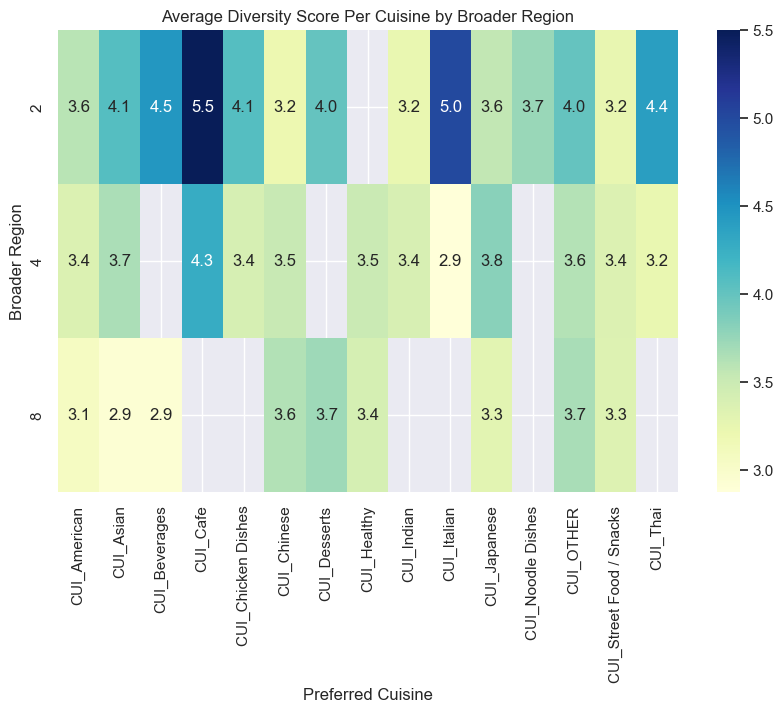

In [293]:
pivot_table_avg_spending = filtered_df_2.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='cui_diversity_score',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Diversity Score Per Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


#### Cluster 3

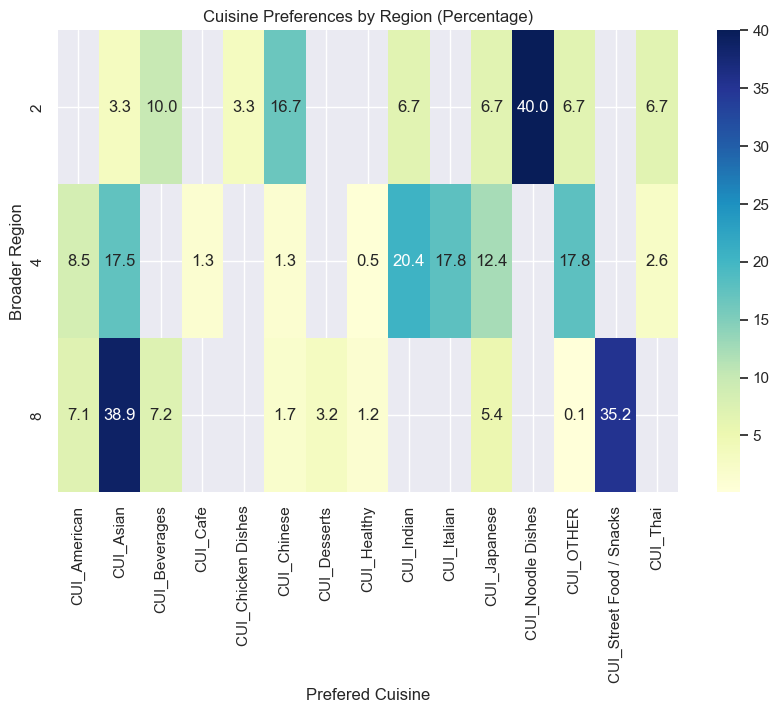

In [294]:
pivot_table_percentage = filtered_df_3.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    aggfunc='size')

# Convert counts to percentages
pivot_table_percentage = pivot_table_percentage.div(pivot_table_percentage.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_percentage, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Cuisine Preferences by Region (Percentage)")
plt.xlabel("Prefered Cuisine")
plt.ylabel("Broader Region")
plt.show()


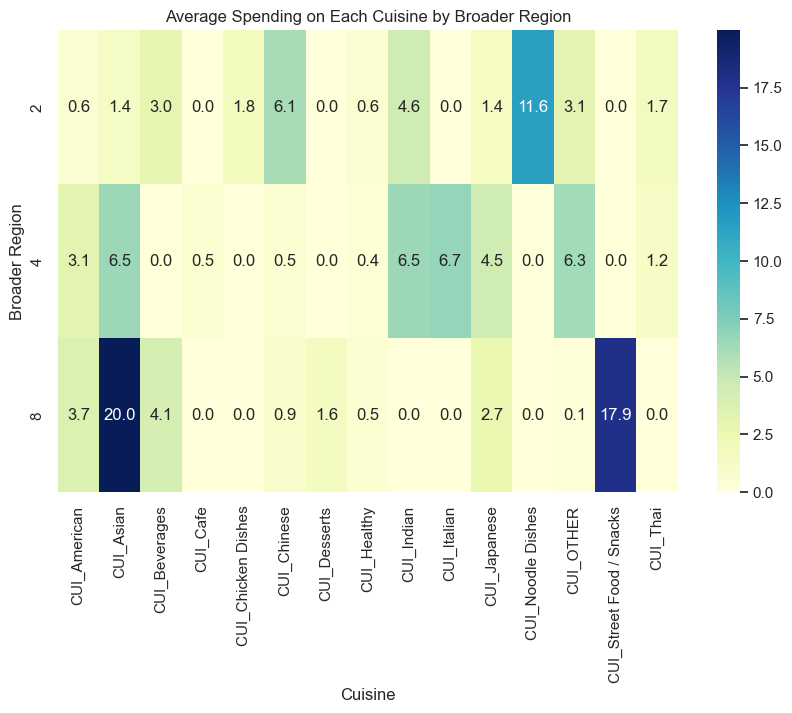

In [295]:
avg_spending_by_region = filtered_df_3.groupby('broader_region')[cuisine_columns].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(avg_spending_by_region, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending on Each Cuisine by Broader Region")
plt.xlabel("Cuisine")
plt.ylabel("Broader Region")
plt.show()


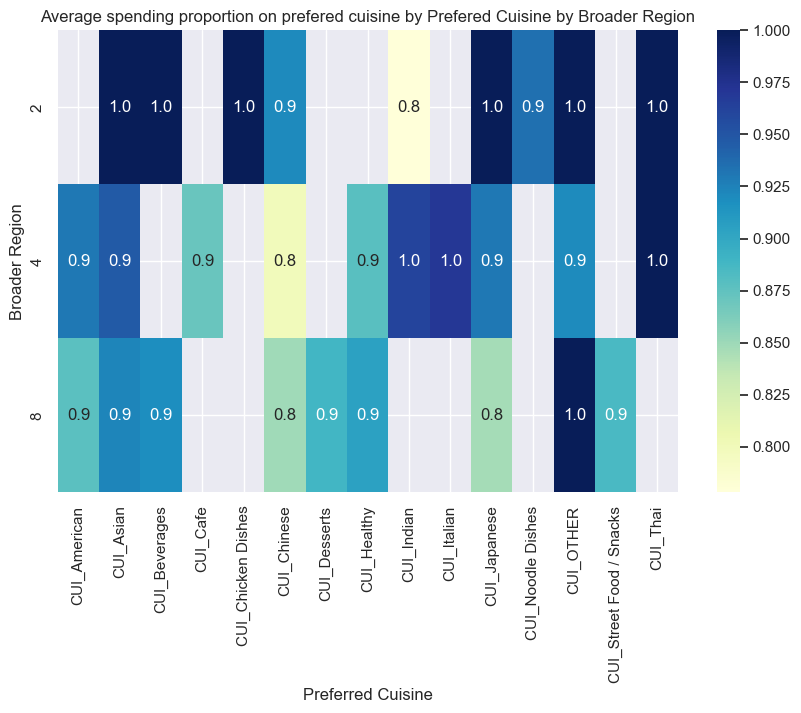

In [296]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_3.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='favourite_cuisine_proportion',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average spending proportion on prefered cuisine by Prefered Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


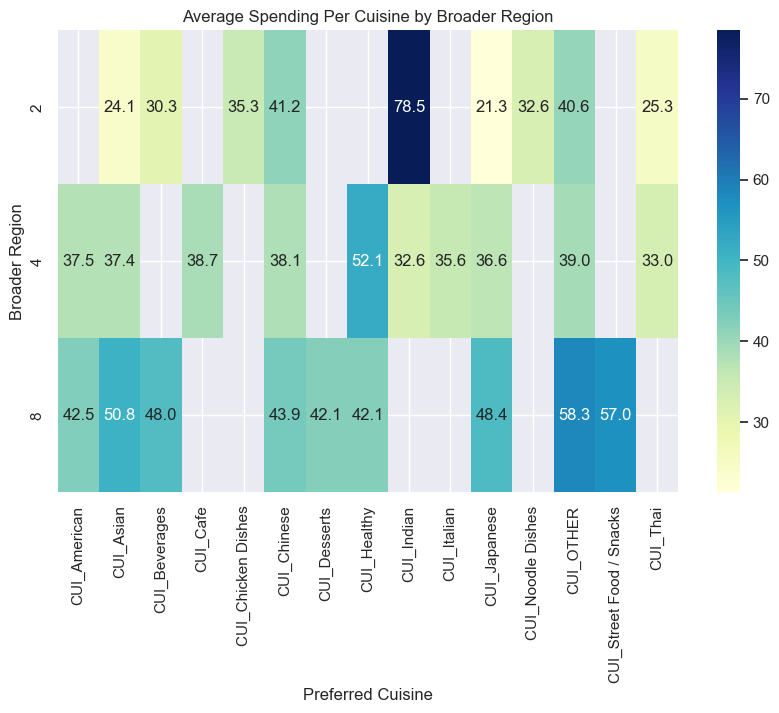

In [297]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_3.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='total_spending',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Spending Per Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


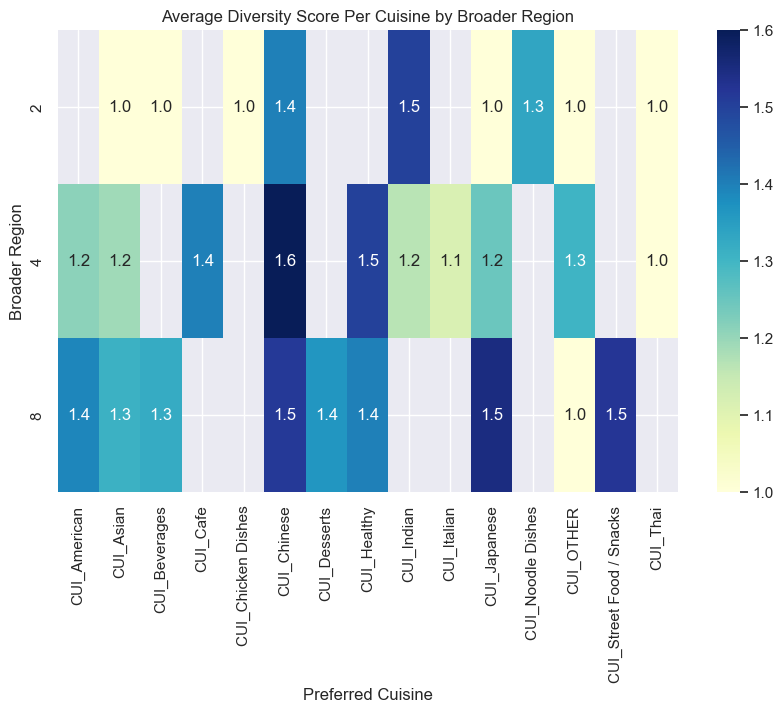

In [298]:
# Create a pivot table to calculate the average spending per cuisine by region
pivot_table_avg_spending = filtered_df_3.pivot_table(
    index='broader_region',
    columns='prefered_cuisine',
    values='cui_diversity_score',
    aggfunc='mean',  # Calculate the average spending
)

# Plot the heatmap to visualize average spending
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_avg_spending, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Diversity Score Per Cuisine by Broader Region")
plt.xlabel("Preferred Cuisine")
plt.ylabel("Broader Region")
plt.show()


### Profiling Conclusion

`CLuster 0`

- Corresponds to **less engaged customers, low-spending and sporadic customers**. We have very few customers with a high order span, and most of them are older customers. They do not spend much in our app and place very few orders, even if they have a high order span. 

- They are equally spread across the 3 different broader regions and half of them use promotions. They usually purchase in the morning and in the afternnon/evening and not at dawn. They have as well very low diversity scores, probably as a consequence of their little engagement. Half of the customers in this cluster use promotions, so this might be a good way to engage them.



`Cluster 1`

- Corresponds to **loyal and engaged customers**, that have been using the app for a long period of time. They order frequently and are the most diverse customers when it comes to the type of cuisines they order and to the days of the week and the hours of the day in which they order. They do not spend much per order so they are not our highest spending customers, but are the ones with the most engagement in the app.

- They are mostly from broader region 2 and some from broader region 4. 

- They order mostly in the morning and in the afternoon/evening. They place very few orders at dawn.

- They tend to prefer American, Asian and OTHER cuisine types and chain restaurants. 



`Cluster 2`

- Corresponds to **high-spending** customers. They place fewer, more expensive orders compared to cluster 1. They are still engaged customers, that are active in the app for a significant time period. They are less diverse when it comes to the cuisine type they order from and to hours of the day and days of the week when they place orders.

- They are mostly from broader region 8 and 4.

- They tend to prefer American and Asian cuisine type. 50% of the customers in this cluster ordered at least once Asian and American cuisine types. 


`Cluster 3`

- Corresponds to **very little engaged** customers that have **very high average order cost**. They are not active in the app, as they have a very low order span. 

- Most customers in this cluster are from broader region 8 and have a significant percentage ordering at dawn (36%).

- Most of the customers in this cluster use promotions and prefer Asian and Street Food / Snacks cuisine type. 

### Dividing cluster 0 into 3 different clusters based on broader region

We decided to divide cluster 0 into 3 clusters, based on broader region. This feature is good on doing segmentation based on cuisine preferences, which will probably help us on targeting marketing strategies that will increase the engagement of customers in our app.

In [299]:
df['merged_labels'].value_counts()

merged_labels
0    22755
1     3631
2     2808
3     2478
Name: count, dtype: int64

In [300]:
df_final_clusters=df.copy()

In [301]:
region_to_label = {
    2: 0.2,
    4: 0.4,
    8: 0.8
}

# Apply the mapping to the merged_labels column, but only where the current label is 2
df_final_clusters['merged_labels'] = df_final_clusters.apply(
    lambda row: region_to_label[row['broader_region']] if row['merged_labels'] == 0 else row['merged_labels'], axis=1
)

In [302]:
df_final_clusters['merged_labels'].value_counts()

merged_labels
0.2    8283
0.4    7920
0.8    6552
1.0    3631
2.0    2808
3.0    2478
Name: count, dtype: int64

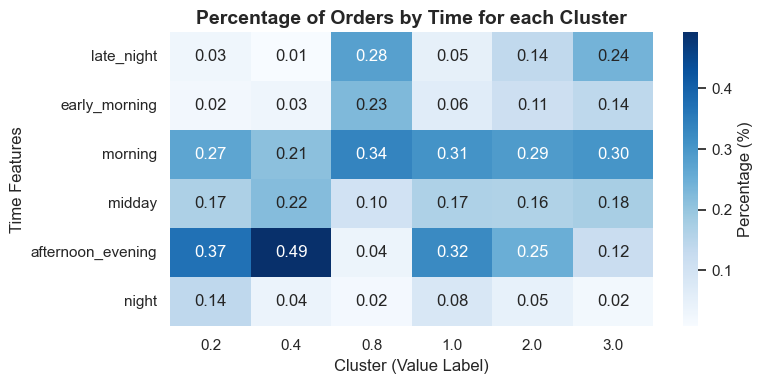

In [303]:
means = df_final_clusters.groupby('merged_labels')[time_features].mean()

# Convert to percentages
percentages = (means.T / means.sum(axis=1))

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(percentages, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
plt.title("Percentage of Orders by Time for each Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Cluster (Value Label)", fontsize=12)
plt.ylabel("Time Features", fontsize=12)
plt.tight_layout()
plt.show()

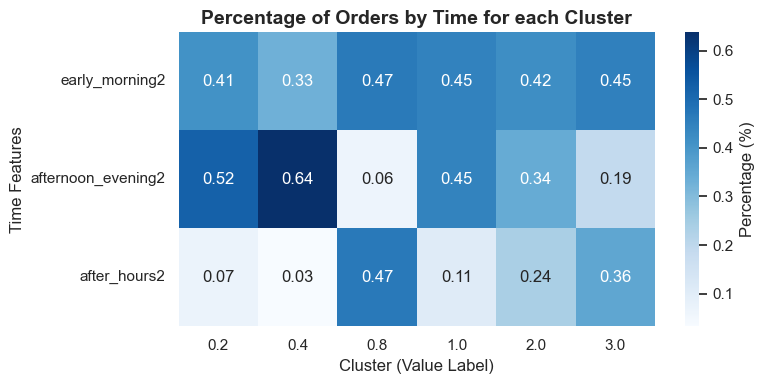

In [304]:
time_features2 = ['early_morning2',
       'afternoon_evening2', 'after_hours2']

# Calculate the means grouped by clusters
means = df_final_clusters.groupby('merged_labels')[time_features2].mean()

# Convert to percentages
percentages = (means.T / means.sum(axis=1))

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(percentages, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
plt.title("Percentage of Orders by Time for each Cluster", fontsize=14, fontweight='bold')
plt.xlabel("Cluster (Value Label)", fontsize=12)
plt.ylabel("Time Features", fontsize=12)
plt.tight_layout()
plt.show()

In [305]:
df_final_clusters[df_final_clusters['merged_labels']==0.2][columns_of_interst].describe()

customer_age  vendor_count  product_count     is_chain  first_order  \
count   8283.000000   8283.000000    8283.000000  8283.000000  8283.000000   
mean      27.417240      2.373778       3.451889     2.423880    29.411083   
std        7.154419      1.275916       2.099136     1.483173    23.215643   
min       15.000000      1.000000       1.000000     0.000000     0.000000   
25%       22.000000      1.000000       2.000000     1.000000    10.000000   
50%       26.000000      2.000000       3.000000     2.000000    25.000000   
75%       30.000000      3.000000       5.000000     3.000000    44.000000   
max       79.000000      6.000000      15.000000     6.000000    90.000000   

        last_order  total_spending  total_orders  order_frequency  \
count  8283.000000     8283.000000   8283.000000      8283.000000   
mean     58.645298       12.792757      2.777496         9.013922   
std      23.336648        8.769118      1.508686         8.313113   
min       0.000000        0.370000      1.000000         0.000000   
25%      42.000000        6.820000      2.000000         0.000000   
50%      63.000000       10.550000      2.000000         8.166667   
75%      79.000000       16.705000      4.000000        14.000000   
max      90.000000       68.800000      6.000000        43.500000   

        order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  8283.000000       8283.000000     8283.000000          8283.000000   
mean     29.234215          3.859884        4.953325             1.511282   
std      26.169150          1.562608        2.801325             0.780615   
min       0.000000          0.370000        0.370000             1.000000   
25%       0.000000          2.820000        3.009000             1.000000   
50%      26.000000          3.630000        4.290000             1.333333   
75%      51.000000          4.610000        6.200833             1.750000   
max      90.000000         14.120000       20.520000            12.000000   

       cui_diversity_score  
count          8283.000000  
mean              2.061089  
std               1.036353  
min               1.000000  
25%               1.000000  
50%               2.000000  
75%               3.000000  
max               6.000000

In [306]:
df_final_clusters[df_final_clusters['merged_labels']==0.2]['prefered_cuisine'].value_counts(normalize=True)

prefered_cuisine
CUI_OTHER                   0.182180
CUI_Chicken Dishes          0.104431
CUI_American                0.099602
CUI_Beverages               0.099119
CUI_Chinese                 0.086804
CUI_Indian                  0.078474
CUI_Noodle Dishes           0.078474
CUI_Asian                   0.074007
CUI_Japanese                0.068091
CUI_Italian                 0.035374
CUI_Thai                    0.032597
CUI_Healthy                 0.020765
CUI_Desserts                0.018472
CUI_Street Food / Snacks    0.015333
CUI_Cafe                    0.006278
Name: proportion, dtype: float64

In [307]:
df_final_clusters[df_final_clusters['merged_labels']==0.2].groupby('prefered_cuisine')['used_promo'].value_counts(normalize=True)

prefered_cuisine          used_promo
CUI_American              1             0.557576
                          0             0.442424
CUI_Asian                 1             0.515498
                          0             0.484502
CUI_Beverages             1             0.528624
                          0             0.471376
CUI_Cafe                  1             0.557692
                          0             0.442308
CUI_Chicken Dishes        1             0.539884
                          0             0.460116
CUI_Chinese               1             0.566064
                          0             0.433936
CUI_Desserts              1             0.516340
                          0             0.483660
CUI_Healthy               1             0.581395
                          0             0.418605
CUI_Indian                1             0.535385
                          0             0.464615
CUI_Italian               0             0.593857
                          1     

In [308]:
df_final_clusters[df_final_clusters['merged_labels']==0.2].groupby('prefered_cuisine')['total_orders'].describe()

count      mean       std  min  25%  50%  75%  max
prefered_cuisine                                                             
CUI_American               825.0  2.804848  1.531062  1.0  2.0  2.0  4.0  6.0
CUI_Asian                  613.0  2.835237  1.529855  1.0  2.0  3.0  4.0  6.0
CUI_Beverages              821.0  2.711328  1.485944  1.0  2.0  2.0  4.0  6.0
CUI_Cafe                    52.0  2.730769  1.415812  1.0  2.0  2.0  4.0  6.0
CUI_Chicken Dishes         865.0  2.772254  1.444231  1.0  2.0  3.0  4.0  6.0
CUI_Chinese                719.0  2.812239  1.541285  1.0  2.0  3.0  4.0  6.0
CUI_Desserts               153.0  2.457516  1.428041  1.0  1.0  2.0  3.0  6.0
CUI_Healthy                172.0  2.755814  1.532769  1.0  1.0  3.0  4.0  6.0
CUI_Indian                 650.0  2.727692  1.449085  1.0  2.0  2.0  4.0  6.0
CUI_Italian                293.0  2.481229  1.368865  1.0  1.0  2.0  3.0  6.0
CUI_Japanese               564.0  2.760638  1.588528  1.0  1.0  2.0  4.0  6.0
CUI_Noodle Dishes          650.0  2.943077  1.569594  1.0  2.0  3.0  4.0  6.0
CUI_OTHER                 1509.0  2.823062  1.515560  1.0  2.0  3.0  4.0  6.0
CUI_Street Food / Snacks   127.0  2.771654  1.404013  1.0  2.0  3.0  4.0  6.0
CUI_Thai                   270.0  2.718519  1.543192  1.0  1.0  2.0  4.0  6.0

In [309]:
df_final_clusters[df_final_clusters['merged_labels']==0.2].groupby('prefered_cuisine')['avg_order_cost'].describe()

count      mean       std       min       25%  \
prefered_cuisine                                                           
CUI_American               825.0  4.204996  2.367157  0.410000  2.633333   
CUI_Asian                  613.0  5.005679  2.467761  0.630000  3.203333   
CUI_Beverages              821.0  4.524206  2.454233  0.740000  2.803333   
CUI_Cafe                    52.0  5.848923  3.461964  1.510000  3.763750   
CUI_Chicken Dishes         865.0  4.501997  2.417917  0.420000  2.885000   
CUI_Chinese                719.0  5.288789  3.068401  0.600000  3.067500   
CUI_Desserts               153.0  4.924723  2.815227  0.990000  2.866667   
CUI_Healthy                172.0  4.278756  2.710967  0.910000  2.570417   
CUI_Indian                 650.0  5.430307  2.760897  0.940000  3.511667   
CUI_Italian                293.0  4.191614  2.423658  0.880000  2.545000   
CUI_Japanese               564.0  5.161838  2.938277  0.760000  3.130000   
CUI_Noodle Dishes          650.0  5.889778  3.874829  0.370000  3.080625   
CUI_OTHER                 1509.0  5.086725  2.609357  0.720000  3.233333   
CUI_Street Food / Snacks   127.0  5.203730  2.800571  1.178333  3.253667   
CUI_Thai                   270.0  5.376873  2.933193  0.500000  3.433750   

                               50%       75%        max  
prefered_cuisine                                         
CUI_American              3.628000  5.212500  17.000000  
CUI_Asian                 4.455000  6.440000  15.610000  
CUI_Beverages             3.990000  5.435000  20.450000  
CUI_Cafe                  4.592500  7.345000  20.120000  
CUI_Chicken Dishes        3.980000  5.623333  19.296667  
CUI_Chinese               4.604000  6.660833  20.520000  
CUI_Desserts              4.238333  6.287500  15.390000  
CUI_Healthy               3.740000  5.055000  17.950000  
CUI_Indian                4.790000  6.736875  19.880000  
CUI_Italian               3.500000  5.390000  15.040000  
CUI_Japanese              4.456667  6.533750  19.220000  
CUI_Noodle Dishes         4.726667  7.583750  19.940000  
CUI_OTHER                 4.514000  6.380000  17.110000  
CUI_Street Food / Snacks  4.690000  6.341667  16.920000  
CUI_Thai                  4.557500  6.655000  18.590000

In [310]:
df_final_clusters[df_final_clusters['merged_labels']==0.2][time_features].describe()

late_night  early_morning      morning       midday  \
count  8283.000000    8283.000000  8283.000000  8283.000000   
mean      0.076663       0.064349     0.752384     0.466618   
std       0.349270       0.284151     1.015405     0.745227   
min       0.000000       0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000   
50%       0.000000       0.000000     0.000000     0.000000   
75%       0.000000       0.000000     1.000000     1.000000   
max       5.000000       3.000000     6.000000     6.000000   

       afternoon_evening        night  
count        8283.000000  8283.000000  
mean            1.027406     0.390076  
std             1.102498     0.729105  
min             0.000000     0.000000  
25%             0.000000     0.000000  
50%             1.000000     0.000000  
75%             2.000000     1.000000  
max             6.000000     6.000000

In [311]:
df_final_clusters[df_final_clusters['merged_labels']==0.4][columns_of_interst].describe()

customer_age  vendor_count  product_count     is_chain  first_order  \
count   7920.000000   7920.000000    7920.000000  7920.000000  7920.000000   
mean      27.516288      2.034343       3.176136     1.311616    33.081818   
std        7.116336      1.080581       1.872407     1.350400    24.658181   
min       15.000000      1.000000       1.000000     0.000000     0.000000   
25%       23.000000      1.000000       2.000000     0.000000    12.000000   
50%       26.000000      2.000000       3.000000     1.000000    28.000000   
75%       31.000000      3.000000       4.000000     2.000000    52.000000   
max       80.000000      6.000000      10.000000     6.000000    89.000000   

        last_order  total_spending  total_orders  order_frequency  \
count  7920.000000     7920.000000   7920.000000      7920.000000   
mean     62.038005       23.511975      2.672727         9.201618   
std      23.288593       13.849894      1.459981         8.704554   
min       0.000000        1.120000      1.000000         0.000000   
25%      47.000000       13.420000      1.000000         0.000000   
50%      69.000000       19.990000      2.000000         8.200000   
75%      82.000000       31.400000      4.000000        14.400000   
max      89.000000       69.280000      6.000000        44.000000   

        order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  7920.000000       7920.000000     7920.000000          7920.000000   
mean     28.956187          7.866854        9.326401             1.654257   
std      26.535425          2.909240        3.893062             0.951122   
min       0.000000          1.100000        1.100000             1.000000   
25%       0.000000          6.000000        6.427292             1.000000   
50%      25.000000          7.416667        8.615500             1.333333   
75%      51.000000          9.150000       11.605000             2.000000   
max      89.000000         20.830000       20.880000             9.000000   

       cui_diversity_score  
count          7920.000000  
mean              1.760354  
std               0.859872  
min               1.000000  
25%               1.000000  
50%               2.000000  
75%               2.000000  
max               6.000000

In [312]:
df_final_clusters[df_final_clusters['merged_labels']==0.4].groupby('prefered_cuisine')['used_promo'].value_counts(normalize=True)

prefered_cuisine          used_promo
CUI_American              0             0.532686
                          1             0.467314
CUI_Asian                 0             0.532990
                          1             0.467010
CUI_Cafe                  1             0.529630
                          0             0.470370
CUI_Chicken Dishes        1             0.510204
                          0             0.489796
CUI_Chinese               0             0.613333
                          1             0.386667
CUI_Healthy               0             0.564767
                          1             0.435233
CUI_Indian                0             0.529887
                          1             0.470113
CUI_Italian               0             0.657262
                          1             0.342738
CUI_Japanese              0             0.530137
                          1             0.469863
CUI_OTHER                 0             0.552184
                          1     

In [313]:
df_final_clusters[df_final_clusters['merged_labels']==0.4][time_features].describe()

late_night  early_morning      morning       midday  \
count  7920.000000    7920.000000  7920.000000  7920.000000   
mean      0.022096       0.083838     0.564015     0.586869   
std       0.173046       0.353635     0.918276     0.850353   
min       0.000000       0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000   
50%       0.000000       0.000000     0.000000     0.000000   
75%       0.000000       0.000000     1.000000     1.000000   
max       3.000000       5.000000     6.000000     6.000000   

       afternoon_evening        night  
count        7920.000000  7920.000000  
mean            1.316035     0.099874  
std             1.215714     0.377750  
min             0.000000     0.000000  
25%             0.000000     0.000000  
50%             1.000000     0.000000  
75%             2.000000     0.000000  
max             6.000000     4.000000

In [314]:
df_final_clusters[df_final_clusters['merged_labels']==0.8][columns_of_interst].describe()

customer_age  vendor_count  product_count     is_chain  first_order  \
count   6552.000000   6552.000000    6552.000000  6552.000000  6552.000000   
mean      27.412546      2.240079       2.917125     1.393315    32.900488   
std        6.996607      1.124881       1.631060     1.169463    24.205183   
min       15.000000      1.000000       1.000000     0.000000     0.000000   
25%       23.000000      1.000000       2.000000     1.000000    12.000000   
50%       26.000000      2.000000       3.000000     1.000000    29.000000   
75%       30.000000      3.000000       4.000000     2.000000    51.000000   
max       80.000000      6.000000       9.000000     6.000000    89.000000   

        last_order  total_spending  total_orders  order_frequency  \
count  6552.000000     6552.000000   6552.000000      6552.000000   
mean     60.245421       28.871212      2.516484         9.360071   
std      23.546475       15.237416      1.284111         8.831237   
min       0.000000        0.470000      1.000000         0.000000   
25%      46.000000       18.260000      2.000000         0.500000   
50%      66.000000       24.815000      2.000000         8.000000   
75%      80.000000       37.292500      3.000000        15.000000   
max      89.000000       69.610000      6.000000        44.500000   

        order_span  avg_product_cost  avg_order_cost  products_per_vendor  \
count  6552.000000       6552.000000     6552.000000          6552.000000   
mean     27.344933         10.555057       11.973147             1.317534   
std      25.361133          3.494016        4.158793             0.555609   
min       0.000000          0.470000        0.470000             1.000000   
25%       1.000000          8.505286        8.913750             1.000000   
50%      22.000000          9.975833       11.979000             1.000000   
75%      48.000000         12.110000       15.306250             1.500000   
max      89.000000         20.590000       20.590000             7.000000   

       cui_diversity_score  
count          6552.000000  
mean              1.749389  
std               0.791932  
min               1.000000  
25%               1.000000  
50%               2.000000  
75%               2.000000  
max               6.000000

In [315]:
df_final_clusters[df_final_clusters['merged_labels']==0.8].groupby('prefered_cuisine')['used_promo'].value_counts(normalize=True)

prefered_cuisine          used_promo
CUI_American              1             0.551412
                          0             0.448588
CUI_Asian                 1             0.528181
                          0             0.471819
CUI_Beverages             1             0.544715
                          0             0.455285
CUI_Chinese               1             0.547297
                          0             0.452703
CUI_Desserts              1             0.534954
                          0             0.465046
CUI_Healthy               1             0.571429
                          0             0.428571
CUI_Japanese              1             0.579055
                          0             0.420945
CUI_OTHER                 1             0.666667
                          0             0.333333
CUI_Street Food / Snacks  1             0.514007
                          0             0.485993
Name: proportion, dtype: float64

In [316]:
df_final_clusters[df_final_clusters['merged_labels']==0.8][time_features].describe()

late_night  early_morning      morning       midday  \
count  6552.000000    6552.000000  6552.000000  6552.000000   
mean      0.704976       0.569750     0.848443     0.256868   
std       0.967864       0.814137     1.000267     0.575102   
min       0.000000       0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000   
50%       0.000000       0.000000     1.000000     0.000000   
75%       1.000000       1.000000     1.000000     0.000000   
max       6.000000       5.000000     6.000000     5.000000   

       afternoon_evening        night  
count        6552.000000  6552.000000  
mean            0.089133     0.047314  
std             0.352054     0.245656  
min             0.000000     0.000000  
25%             0.000000     0.000000  
50%             0.000000     0.000000  
75%             0.000000     0.000000  
max             6.000000     4.000000

#### Final Conclusion on the new clusters

The new clusters have the same caracteristics as the previous cluster **0** when it comes to metric features, they now differ based on the type of cuisine the customers order most.



`Cluster 0.2`

The customers in this cluster have a lot of diversity when it comes to the prefered cuisine from which they order from. Most customers have as their prefered cuisine CUI_OTHER, followed by CUI_Chicken_Dishes and CUI_American. It will be important to do a marketing strategy taking into consideration this diversity, but more focused on the prefered types of cuisine. 


`Cluster 0.4`

The customers in this cluster are less diverse when it comes to the cuisine they prefer. They tend to order mostly Italian and American cuisine types, so marketing strategies should be focused on that type of cuisines. There are cuisines that should not be advertise in this cluster, as the customers do not order from that specific types.

`Cluster 0.8`

In this clusters customers are very little diverse when it comes to the type of cuisine they order from. The order mostly from Asian cuisine type, followed by American and Street Food / Snacks cuisine types. There are 6 types of cuisines Marketing strategies should be developed accordingly. There are cuisines that should not be advertise in this cluster, as the customers do not order from that specific types.